# Modelling for Aggression Level Classification

The notebook contains code for aggression classification models and accompanying EDA. It includes:
- SVM
- K nearst neighbour
- XGBoost 

SVM (using all data with the original 4-level aggression labels and no label balancing) is the baseline model.

## Install Packages

In [129]:
import sys
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install sklearn
# !{sys.executable} -m pip install yellowbrick
# !{sys.executable} -m pip install matplot
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install xgboost

import os  # Ref: https://docs.python.org/3/library/os.html
import copy  # Ref: https://docs.python.org/3/library/copy.html
import numpy as np  # Ref: https://numpy.org
import pandas as pd  # Ref: https://pandas.pydata.org
import matplotlib.pyplot as plt # Ref: https://matplotlib.org
import seaborn as sns  # Ref: https://seaborn.pydata.org

from sklearn.compose import ColumnTransformer  # Ref: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.compose
from sklearn.preprocessing import StandardScaler  # Ref: https://scikit-learn.org/stable/modules/preprocessing.htm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split  # Ref: https://scikit-learn.org/stable/model_selection.html
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report  # Ref: https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.utils import resample  # Ref: https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html

from sklearn import svm, mixture  # Ref: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm 
from sklearn.neighbors import KNeighborsClassifier  # Ref: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
from sklearn.tree import DecisionTreeClassifier  # Ref: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier  # Ref: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from xgboost import XGBClassifier  # Ref: https://xgboost.readthedocs.io/en/stable/python/python_api.html

## Data Pre-processing

In [130]:
# Helper function: reads csv file and return it as a dataframe
def read_data(data_file):
  data_df = pd.read_csv(data_file)
  return data_df

def drop_features(data_df, features_to_drop):
  return data_df.drop(columns=features_to_drop, inplace=True)

def segregate_noisy_data(data_df):
  copied_data = copy.deepcopy(data_df)
  non_noisy_df = copied_data.loc[(copied_data['noisy_train'] == 0)]
  noisy_df = copied_data.loc[(copied_data['noisy_train'] == 1)]
  return non_noisy_df, noisy_df

def remove_noisy_data(data_df):
  # Remove data with noisy = 1
  print(f'''Rows dropped because of noisy == 1: 
        {len(data_df[data_df['noisy'] == 1])}\n''')
  
  return data_df.drop(data_df[data_df['noisy'] == 1].index, inplace=True)

# Helper function: Cleans data based on duration and extracts filenames
def preprocessing_data(data_df):
  # Drop rows with duration < 2
  print(f'''Rows dropped because of low duration: \
        {len(data_df[data_df['duration'] < 2])}\n''')
  
  data_df.drop(data_df[data_df['duration'] < 2].index, inplace=True)

  # Extract filenames
  filenames = data_df['file_name'].values.tolist()

  return (data_df, filenames)


### Read Data

In [131]:
# Fetch .csv file and store it as a dataframe
aggression_data_df = read_data('../extracted/full-train-features.csv')

### Data Cleaning

In [132]:
print(f'Shape of the data before cleaning: {aggression_data_df.shape}\n')

aggression_data_df, filenames = preprocessing_data(aggression_data_df)

print(f'Shape of the data after cleaning: {aggression_data_df.shape} \n')
display(aggression_data_df.head(1))

Shape of the data before cleaning: (2146, 23)

Rows dropped because of low duration:         35

Shape of the data after cleaning: (2111, 23) 



,file_name,duration,analyse_harmonics,get_number_sylls,get_number_words,pauses,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,...,mean_spectral_rolloff,get_energy,parent_file_train,number_of_segments_train,number_of_voices_parent_train,extra_sounds_train,parent_label_train,segment_label_train,noisy_train,Notes_train
0,00g8dfgpqpt61_processed_0,10.0,2.071884,NaN,NaN,0.1,108.591944,76.429126,355.354649,517.89915,...,1711.357507,0.174962,00g8dfgpqpt61,3,9999,"clapping, coughing",0,0,1,Only laughing


### Seperate noisy and non-noisy data

In [133]:
non_noisy_df, noisy_df = segregate_noisy_data(aggression_data_df)

print(f"Shape of noisy data: {noisy_df.shape} \n")
print(f"Shape of non noisy data: {non_noisy_df.shape}\n")

Shape of noisy data: (262, 23) 

Shape of non noisy data: (1849, 23)



#### NOTE: Classification Models were built using 3 groups of data. Therefore, below steps are repeated once for each group:**
1. All Data (Noisy and Non Noisy Data)  
2. Non Noisy Data
3. Noisy Data

### Feature Selection

In [134]:
features_to_drop = ['file_name', 'duration','get_number_sylls',
                    'get_number_words', 'pauses',
                    'number_of_segments_train', 'number_of_voices_parent_train',
                    'extra_sounds_train', 'Notes_train']

# drop unnecessary features for Group 1
print(f'Shape of the data for Group 1 before dropping features: {aggression_data_df.shape} \n')
drop_features(aggression_data_df, features_to_drop)

# drop unnecessary features for Group 2
print(f'Shape of the data for Group 2 before dropping features: {non_noisy_df.shape} \n')
drop_features(non_noisy_df, features_to_drop)

# drop unnecessary features for Group 3
print(f'Shape of the data for Group 3 before dropping features: {noisy_df.shape} \n')
drop_features(noisy_df, features_to_drop)


print(f'Shape of the data for Group 1 after dropping features: {aggression_data_df.shape} \n')
print(f'Shape of the data for Group 2 after dropping features: {non_noisy_df.shape} \n')
print(f'Shape of the data for Group 3 after dropping features: {noisy_df.shape} \n')

Shape of the data for Group 1 before dropping features: (2111, 23) 

Shape of the data for Group 2 before dropping features: (1849, 23) 

Shape of the data for Group 3 before dropping features: (262, 23) 

Shape of the data for Group 1 after dropping features: (2111, 14) 

Shape of the data for Group 2 after dropping features: (1849, 14) 

Shape of the data for Group 3 after dropping features: (262, 14) 



### Data Transformation 

In [135]:
# Drop rows with Nan values 
aggression_data_df.dropna(inplace=True)  
non_noisy_df.dropna(inplace=True) 
noisy_df.dropna(inplace=True)

Group 1: 1 row dropped           
Group 2: 1 row dropped 

In [136]:
# Convert 'get_max_intensity' from string to float 
aggression_data_df['get_max_intensity'] = pd.to_numeric(aggression_data_df['get_max_intensity'])
non_noisy_df['get_max_intensity'] = pd.to_numeric(non_noisy_df['get_max_intensity'])
noisy_df['get_max_intensity'] = pd.to_numeric(noisy_df['get_max_intensity'])

noisy_df.head(5)

,analyse_harmonics,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,analyse_shimmer,analyse_jitter,spectral_slope,mean_spectral_rolloff,get_energy,parent_file_train,parent_label_train,segment_label_train,noisy_train
0,2.071884,108.591944,76.429126,355.354649,517.899150,0.193371,0.039075,-0.091534,1711.357507,0.174962,00g8dfgpqpt61,0,0,1
1,1.548685,107.108480,78.207339,409.030438,491.537960,0.202199,0.049623,-0.090760,1469.373610,0.263521,00g8dfgpqpt62,0,0,1
2,2.202973,110.003934,77.650102,393.605328,511.080779,0.200674,0.038352,-0.116676,1287.538989,0.231453,00g8dfgpqpt63,0,0,1
3,4.541632,100.037201,67.432142,358.021668,448.489253,0.201583,0.035544,-0.010975,1251.558111,0.022047,01avx2fm1t961,3,3,1
4,3.790801,98.041081,63.570349,373.512829,519.744413,0.190743,0.046422,-0.004044,1387.495977,0.009121,01avx2fm1t961,3,2,1


In [137]:
# Separate feature and labels for all groups
feature_labels = ['parent_label_train', 'segment_label_train', 'noisy_train']

label_df = aggression_data_df.filter(items=feature_labels)
aggression_df = aggression_data_df#.drop(columns=feature_labels)

label_non_noisy_df = non_noisy_df.filter(items=feature_labels)
aggression_non_noisy_df = non_noisy_df#.drop(columns=feature_labels)

label_noisy_df = noisy_df.filter(items=feature_labels)
aggression_noisy_df = noisy_df#.drop(columns=feature_labels)

label_df.reset_index(drop=True, inplace=True)
aggression_df.reset_index(drop=True, inplace=True)

label_non_noisy_df.reset_index(drop=True, inplace=True)
aggression_non_noisy_df.reset_index(drop=True, inplace=True)

label_noisy_df.reset_index(drop=True, inplace=True)
aggression_noisy_df.reset_index(drop=True, inplace=True)

print(f"Shape of labelled data in Group 1:{label_df.shape} \nShape of data in Group 1: {aggression_df.shape}\n")
print(f"Shape of labelled data in Group 2:{label_non_noisy_df.shape} \nShape of data in Group 2: {aggression_non_noisy_df.shape}\n")
print(f"Shape of labelled data in Group 3:{label_noisy_df.shape} \nShape of data in Group 3: {aggression_noisy_df.shape}\n")

Shape of labelled data in Group 1:(2110, 3) 
Shape of data in Group 1: (2110, 14)

Shape of labelled data in Group 2:(1848, 3) 
Shape of data in Group 2: (1848, 14)

Shape of labelled data in Group 3:(262, 3) 
Shape of data in Group 3: (262, 14)



### Standardization

In [138]:
# Helper function: returns a standardized dataframe
def standardize(df):
    org_features = df.columns
    features = [i for i in df.columns if i not in ['parent_file_train'] + feature_labels]
    
    values_array = df.loc[:, features].values

    # Print data before standardization to compare
    print("Before Standardization \n")
    print("Mean and Standard Deviation")
    print(f"Mean = {np.mean(values_array)} ; Standard Deviation = {np.std(values_array)}")
    print(f"Shape to verify: {values_array.shape} \n")

    # Invoke standardization
    # Numeric columns: Std scaler
    pipeline = ColumnTransformer([
        ('transform_numeric',StandardScaler(),features),    
    ], remainder='passthrough')


    # Transform input vector (features)
    df =  pd.DataFrame(pipeline.fit_transform(df),columns=org_features)
    
    #values_array = StandardScaler().fit_transform(values_array)
    
    values_array = df.loc[:, features].values  # To do the below computation
    # Print data after standardization to compare
    print("After Standardization \n")
    print("Mean and Standard Deviation")
    print(f"Mean = {np.mean(values_array)} ; Standard Deviation = {np.std(values_array)}")
    print(f"Shape to verify: {values_array.shape}")

    return df

In [139]:
# Standardize data for all groups
standardized_aggression_df = standardize(aggression_df)
standardized_non_noisy_df = standardize(aggression_non_noisy_df)
standardized_noisy_df = standardize(aggression_noisy_df)

Before Standardization 

Mean and Standard Deviation
Mean = 207.03214462485482 ; Standard Deviation = 405.89809500083527
Shape to verify: (2110, 10) 

After Standardization 

Mean and Standard Deviation
Mean = -2.323904628500039e-17 ; Standard Deviation = 0.9999999999999954
Shape to verify: (2110, 10)
Before Standardization 

Mean and Standard Deviation
Mean = 207.29693013792163 ; Standard Deviation = 410.78706249224183
Shape to verify: (1848, 10) 

After Standardization 

Mean and Standard Deviation
Mean = 1.3256741784163884e-16 ; Standard Deviation = 1.000000000000001
Shape to verify: (1848, 10)
Before Standardization 

Mean and Standard Deviation
Mean = 205.16449718917747 ; Standard Deviation = 369.5763759893764
Shape to verify: (262, 10) 

After Standardization 

Mean and Standard Deviation
Mean = 1.6776232650728988e-16 ; Standard Deviation = 0.9999999999999989
Shape to verify: (262, 10)


In [140]:
standardized_aggression_df

,analyse_harmonics,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,analyse_shimmer,analyse_jitter,spectral_slope,mean_spectral_rolloff,get_energy,parent_file_train,parent_label_train,segment_label_train,noisy_train
0,-1.229415,0.816248,0.877741,1.42237,0.857657,0.898334,0.355641,-0.331514,0.907009,0.498579,00g8dfgpqpt61,0,0,1
1,-1.369057,0.541133,1.180279,2.008275,0.626936,1.131041,1.008834,-0.322634,0.438397,1.124945,00g8dfgpqpt62,0,0,1
2,-1.194428,1.078107,1.085473,1.8399,0.79798,1.090856,0.310873,-0.620007,0.086267,0.898132,00g8dfgpqpt63,0,0,1
3,-0.570238,-0.770265,-0.652971,1.451482,0.250161,1.114803,0.136983,0.592854,0.016588,-0.582963,01avx2fm1t961,3,3,1
4,-0.770635,-1.140454,-1.310001,1.620578,0.873807,0.829075,0.810602,0.672384,0.279838,-0.674388,01avx2fm1t961,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,-0.323659,-0.014225,-0.292555,-0.274583,0.202622,0.987592,-0.006539,0.479082,-0.465383,-0.480872,xdz15thrnem51,2,1,0
2106,0.053725,0.711694,0.719834,0.365542,-0.350018,-0.25594,-0.565074,-0.215352,-0.424726,0.260425,xdz15thrnem51,2,2,0
2107,-0.589685,0.09044,-0.028897,-0.329049,0.642715,0.087973,0.070198,0.395726,-0.508895,-0.37301,xdz15thrnem51,2,1,0
2108,0.508124,0.954183,0.938286,0.665189,0.878313,-0.251261,-0.670125,-0.523881,-0.187419,0.608156,xdz15thrnem51,2,2,0


## Baseline Models and Experiments

In [141]:
%matplotlib inline
# Helper function: Run GridSearch
def hyperparameter_tuning(ml_model, data, label, parameters):
    clf = GridSearchCV(ml_model, parameters, refit=True, verbose=0, scoring='f1_weighted', n_jobs=-1, error_score='raise')
    clf.fit(data, label)
    print(clf.best_params_)

# Helper function: Fit model, print performance measures and return predictions
def run_model(ml_model, data, label, label_name):
    model = copy.deepcopy(ml_model)
    
    # Only train on this feature set
    feature_set = data.drop(['parent_file_train']+feature_labels,axis=1).columns  # Only these features will be fed to the model
    print('Feature set:',feature_set)
    
    actual_labels = np.empty([0], dtype=int)
    predicted_labels = np.empty([0], dtype=int)

    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.25)
    
    
    model.fit(X_train[feature_set], y_train)
    y_pred = model.predict(X_test[feature_set])
    
    X_test['segment_predictions'] = y_pred  # To store prediction with rest of the data
    #X_test['segment_actual'] = y_test  # To store prediction with rest of the data

    actual_labels = np.append(actual_labels, y_test)
    predicted_labels = np.append(predicted_labels, y_pred)

    acc_score = accuracy_score(y_test, y_pred)
    prec_score = precision_score(y_test, y_pred, average='weighted')
    rec_score = recall_score(y_test, y_pred, average='weighted')
    fone_score = f1_score(y_test, y_pred, average='weighted')

    print(f'F1 score = {fone_score}; Accuracy score = {acc_score} ; Precisison Score = {prec_score}; Recall score = {rec_score}')

    return actual_labels, predicted_labels, X_test

# Helper function: Generate styled Confusion Matrix
def confusion_matrix_graph(model_name, actual_labels, predicted_labels, label_names):
    matrix = confusion_matrix(actual_labels, predicted_labels)

    plt.figure(figsize=(14, 8))
    ax = sns.heatmap(matrix, annot=True, xticklabels=label_names, yticklabels=label_names, cmap="Greens")
    ax.set_title(model_name);
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual');

    print("\n\n Aggregate report \n", classification_report(actual_labels, predicted_labels, target_names=label_names))

    plt.show()    

In [142]:
# Convert to numpy arrays for use later
data_np = standardized_aggression_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_np = label_df['segment_label_train'].to_numpy()

data_non_noisy_np = standardized_non_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_non_noisy_np = label_non_noisy_df['segment_label_train'].to_numpy()

data_noisy_np = standardized_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_noisy_np = label_noisy_df['segment_label_train'].to_numpy()

C:\Users\samee\AppData\Local\Temp\ipykernel_2380\2360135453.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_np = standardized_aggression_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\samee\AppData\Local\Temp\ipykernel_2380\2360135453.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_non_noisy_np = standardized_non_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\samee\AppData\Local\Temp\ipykernel_2380\2360135453.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_noisy_np = standardized_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "no

### Baseline SVM
#### Hyperparameter Tuning

In [143]:
# original_parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': ['scale', 'auto'],
#                    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [1,2,3,4,5,6]}

quick_parameters = {'C': [ 0.001, 0.01, 0.1, 1, 10, 100], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svc = svm.SVC()
# Run seperate gridsearch for each group
# hyperparameter_tuning(svc, data_np, label_np, quick_parameters)
# hyperparameter_tuning(svc, data_non_noisy_np, label_non_noisy_np, quick_parameters)
# hyperparameter_tuning(svc, data_noisy_np, label_noisy_np, quick_parameters)

NOTE: `orginal_parameters` were initially used to tune SVM hyperparameters, but the gridsearch took over 4 hours. Therefore, `quick_parameters` - a smaller subset of the `original_parameters` can be used.

**Hyperparameter Tuning Results**    
-Group 1 (all data): {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}       
-Group 2 (non noisy): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}       
-Group 3 (noisy): {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}        

#### Segment Label vs Parent Label Analysis 
***Analysis of model performance on segment label vs parent label prediction.***

- Our data consists of `segment` audio files and `parent` audio files. 
- `Segment` audio files are smaller subsets of the `parent` audio file.
- Aggression level label of each `segment` is represented by `segment_label`
- Aggression level label of each `parent`, i.e. highest aggression level in all its `segment_labels` is represented by `parent_label`
- *From here on, performance of each classification model will be evaluated for both `segment_label` and `parent_label`.* 

#### Performance of Baseline SVM Model on all Groups - Segment level

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.5109782788719617; Accuracy score = 0.5265151515151515 ; Precisison Score = 0.5251685517508302; Recall score = 0.5265151515151515


 Aggregate report 
               precision    recall  f1-score   support

           0       0.60      0.76      0.67       213
           1       0.43      0.46      0.44       148
           2       0.33      0.23      0.27        91
           3       0.73      0.36      0.48        76

    accuracy                           0.53       528
   macro avg       0.52      0.45      0.47       528
weighted avg       0.53      0.53      0.51       528



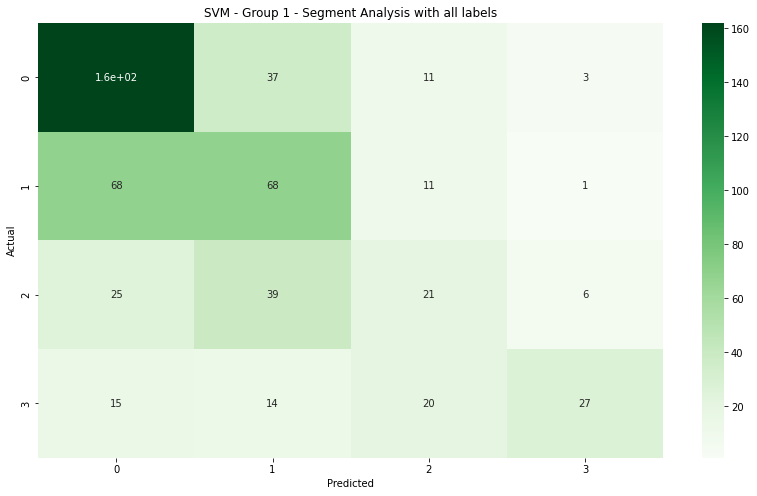

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.542541280280934; Accuracy score = 0.5476190476190477 ; Precisison Score = 0.5533465217259683; Recall score = 0.5476190476190477


 Aggregate report 
               precision    recall  f1-score   support

           0       0.63      0.69      0.66       190
           1       0.50      0.53      0.51       154
           2       0.36      0.35      0.36        80
           3       0.75      0.32      0.44        38

    accuracy                           0.55       462
   macro avg       0.56      0.47      0.49       462
weighted avg       0.55      0.55      0.54       462



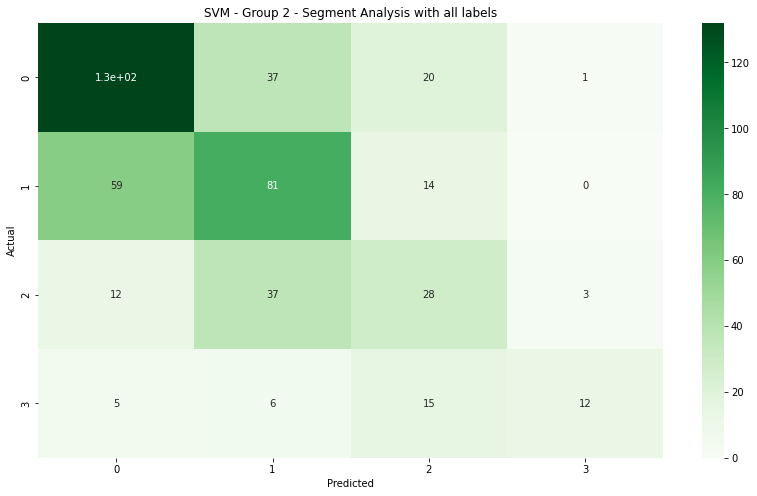

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6672560848762221; Accuracy score = 0.7272727272727273 ; Precisison Score = 0.6378066378066377; Recall score = 0.7272727272727273


 Aggregate report 
               precision    recall  f1-score   support

           0       0.67      0.97      0.79        31
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         8
           3       0.86      0.72      0.78        25

    accuracy                           0.73        66
   macro avg       0.38      0.42      0.39        66
weighted avg       0.64      0.73      0.67        66



C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

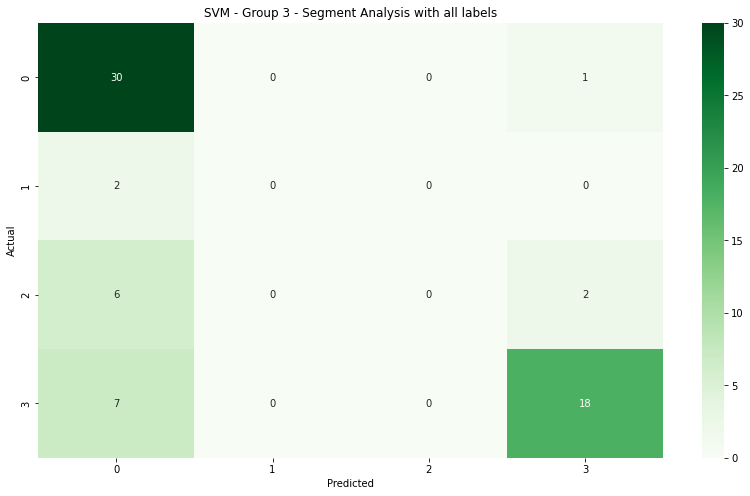

In [144]:
# Store features, labels, and hyperparameters of each group for iteration
lst_label_np = [label_np, label_non_noisy_np, label_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df, standardized_non_noisy_df, standardized_noisy_df]
X_test_list = [None,None,None]
gamma = ['auto', 'scale', 'auto']
c = [1, 10, 1]

# Fit model and evaluate performance for the 3 groups 
for i in range(3):
    svm_model = svm.SVC(kernel='rbf', gamma=gamma[i], C=c[i])
    actual, predicted, X_test_list[i] = run_model(svm_model, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"SVM - Group {i+1} - Segment Analysis with all labels", actual, predicted, ['0', '1', '2', '3'])

#### Performance of Baseline SVM Model on all Groups - Parent level



 Aggregate report 
               precision    recall  f1-score   support

           0       0.50      0.74      0.60        70
           1       0.36      0.40      0.38        52
           2       0.37      0.23      0.29        47
           3       0.85      0.39      0.53        44

    accuracy                           0.47       213
   macro avg       0.52      0.44      0.45       213
weighted avg       0.51      0.47      0.46       213



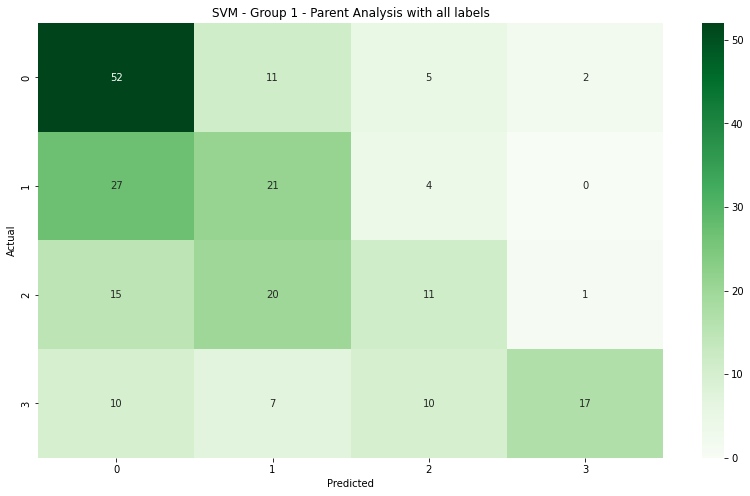



 Aggregate report 
               precision    recall  f1-score   support

           0       0.46      0.59      0.52        54
           1       0.30      0.37      0.33        46
           2       0.35      0.34      0.34        44
           3       0.88      0.22      0.35        32

    accuracy                           0.40       176
   macro avg       0.50      0.38      0.39       176
weighted avg       0.47      0.40      0.40       176



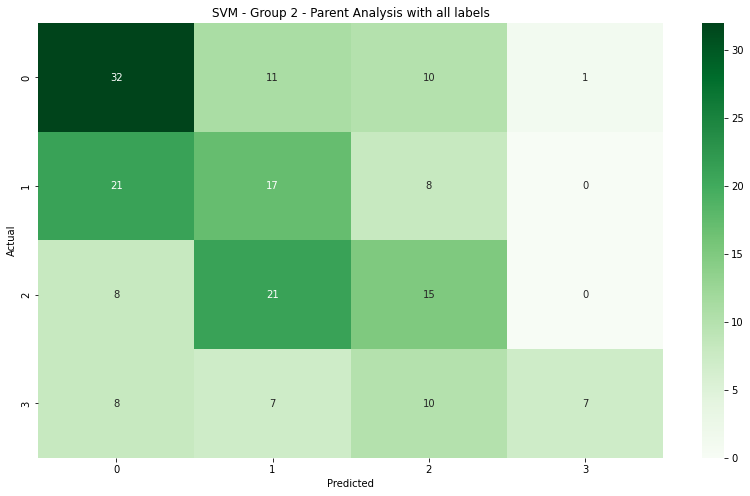



 Aggregate report 
               precision    recall  f1-score   support

           0       0.55      1.00      0.71        17
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         4
           3       1.00      0.62      0.76        13

    accuracy                           0.64        39
   macro avg       0.39      0.40      0.37        39
weighted avg       0.57      0.64      0.56        39



C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

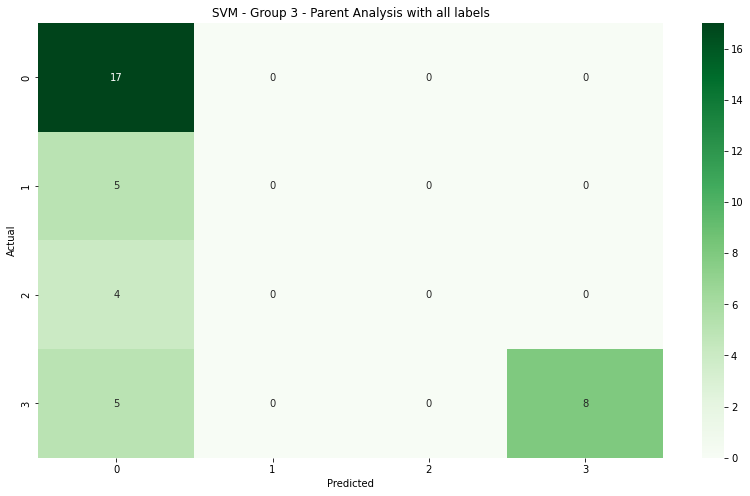

In [145]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"SVM - Group {i+1} - Parent Analysis with all labels", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

### Experiment: Combine Labels
Instead of having 4 distinct aggression levels (labels) - 0, 1, 2, 3, merge 1 and 2 to reduce to 3 distinct labels - 0, 1, 2 to improve classification performance.    
- **Labels 1 and 2 were combined** as label 1 for all 3 groups and for both segment and parent labels. This decision was made based on Label Variation Analysis conducted in IOE_script.ipynb.     
- Original label 3 was changed to label 2.

In [146]:
standardized_aggression_mergedlabels_df = standardized_aggression_df.copy()

# Combine segment level labels
standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['segment_label_train'] == 2, 'segment_label_train' ] = 1
standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['segment_label_train'] == 3, 'segment_label_train'] = 2
# Combine parent level labels
standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['parent_label_train'] == 2, 'parent_label_train'] = 1
standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['parent_label_train'] == 3, 'parent_label_train'] = 2

print(standardized_aggression_mergedlabels_df['segment_label_train'].unique())  # Print final labels
print(standardized_aggression_mergedlabels_df['parent_label_train'].unique())  #  Print final labels

[0 2 1]
[0 2 1]


In [147]:
# Split original standardized dat into non-noisy and noisy
standardized_mergedlabels_non_noisy_df = standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['noisy_train'] == 0]
standardized_mergedlabels_noisy_df = standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['noisy_train'] == 1]

In [148]:
# Convert to numpy arrays for the three groups (all data, non-noisy, noisy)
data_merged_np = standardized_aggression_mergedlabels_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_merged_np = standardized_aggression_mergedlabels_df['segment_label_train'].to_numpy()
label_merged_np=label_merged_np.astype('int')

data_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df['segment_label_train'].to_numpy()
label_merged_non_noisy_np=label_merged_non_noisy_np.astype('int')

data_merged_noisy_np = standardized_mergedlabels_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_merged_noisy_np = standardized_mergedlabels_noisy_df['segment_label_train'].to_numpy()
label_merged_noisy_np=label_merged_noisy_np.astype('int')

C:\Users\samee\AppData\Local\Temp\ipykernel_2380\2632166679.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_merged_np = standardized_aggression_mergedlabels_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\samee\AppData\Local\Temp\ipykernel_2380\2632166679.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\samee\AppData\Local\Temp\ipykernel_2380\2632166679.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_merged_noisy_np = standardized_mergedlabels_noisy_df.drop(["parent_

#### Hyperparameter Tuning

In [149]:
quick_parameters = {'C': [ 0.001, 0.01, 0.1, 1, 10, 100], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svc = svm.SVC()
# hyperparameter_tuning(svc, data_merged_np, label_merged_np, quick_parameters)
# hyperparameter_tuning(svc, data_merged_non_noisy_np, label_merged_non_noisy_np, quick_parameters)
# hyperparameter_tuning(svc, data_merged_noisy_np, label_merged_noisy_np, quick_parameters)

NOTE: Avoid running Hyperparamater tuning as it takes a lot of time.   

**Hyperparameter Tuning Results:**
- Group 1 (all data): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
- Group 2 (non-noisy): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
- Group 3 (noisy): {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

#### Performance of SVM Model with Combined Labels on all Groups - Segment level

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.627226300468608; Accuracy score = 0.6325757575757576 ; Precisison Score = 0.6361830682973544; Recall score = 0.6325757575757576


 Aggregate report 
               precision    recall  f1-score   support

           0       0.72      0.65      0.68       243
           1       0.58      0.70      0.63       226
           2       0.52      0.29      0.37        59

    accuracy                           0.63       528
   macro avg       0.60      0.55      0.56       528
weighted avg       0.64      0.63      0.63       528



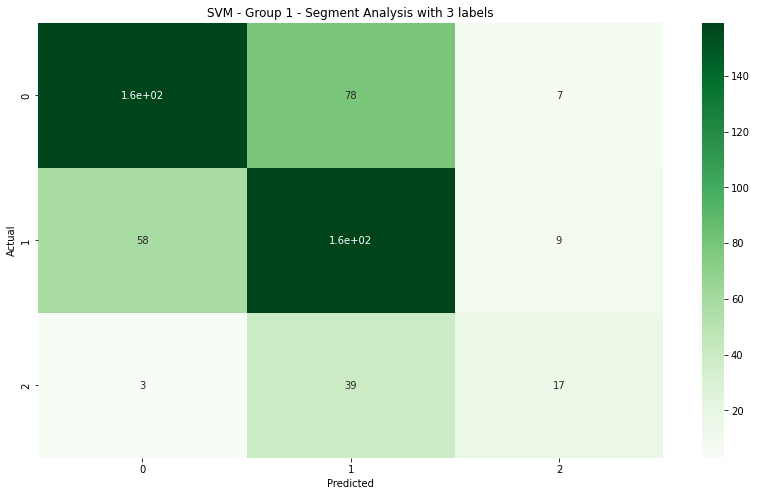

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6736274817826065; Accuracy score = 0.6774891774891775 ; Precisison Score = 0.6837425016878298; Recall score = 0.6774891774891775


 Aggregate report 
               precision    recall  f1-score   support

           0       0.67      0.66      0.66       182
           1       0.67      0.74      0.70       238
           2       0.81      0.40      0.54        42

    accuracy                           0.68       462
   macro avg       0.72      0.60      0.64       462
weighted avg       0.68      0.68      0.67       462



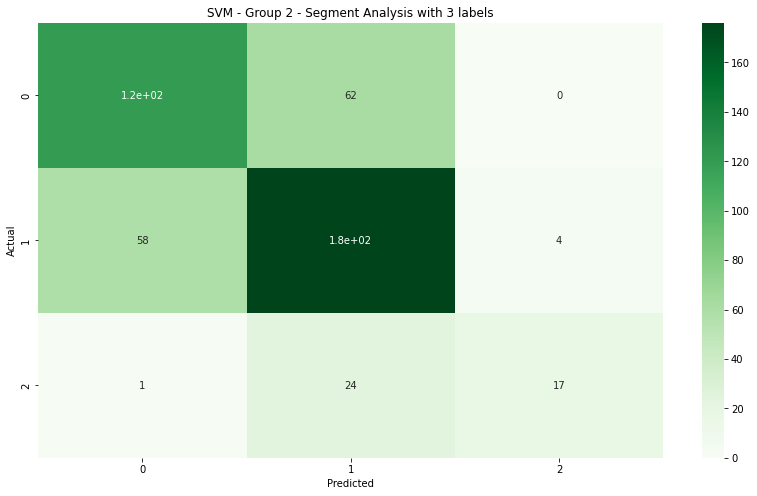

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.5819011005578169; Accuracy score = 0.6818181818181818 ; Precisison Score = 0.5077466393255867; Recall score = 0.6818181818181818


 Aggregate report 
               precision    recall  f1-score   support

           0       0.74      0.97      0.84        29
           1       0.00      0.00      0.00        17
           2       0.61      0.85      0.71        20

    accuracy                           0.68        66
   macro avg       0.45      0.61      0.51        66
weighted avg       0.51      0.68      0.58        66



C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

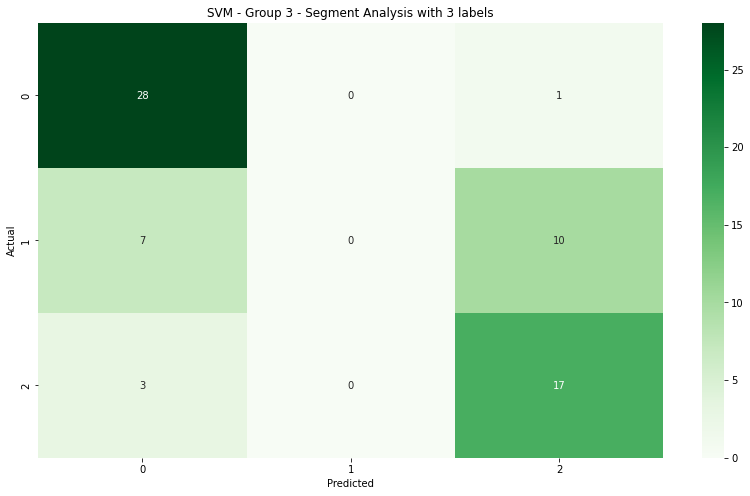

In [150]:
lst_label_np = [label_merged_np, label_merged_non_noisy_np, label_merged_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_mergedlabels_df, standardized_mergedlabels_non_noisy_df, standardized_mergedlabels_noisy_df]
X_test_list = [None,None,None]
kernel = ['rbf', 'rbf', 'linear']
c = [10, 10, 0.1]

for i in range(3):
    svm_model = svm.SVC(kernel=kernel[i], gamma='scale', C=c[i])
    actual, predicted, X_test_list[i] = run_model(svm_model, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"SVM - Group {i+1} - Segment Analysis with 3 labels", actual, predicted, ['0', '1', '2'])

**Performance analysis of Combining Labels - Segment Level**

1. There seems to be an improvement in Accuracy and f1 scores after combining labels.
2. The model performs significantly better than 4 label baseline at identifying the middle level (label 1) in Groups 1 and 2.  This can be seen in the confusion matrices above.
3. The model continues to perform well for extreme aggression levels (label 1 and label 2) in Group 3.

#### Performance of SVM Model with Combined Labels on all Groups - Parent level



 Aggregate report 
               precision    recall  f1-score   support

           0       0.62      0.61      0.62        70
           1       0.56      0.71      0.63        93
           2       0.62      0.31      0.42        48

    accuracy                           0.59       211
   macro avg       0.60      0.55      0.55       211
weighted avg       0.60      0.59      0.58       211



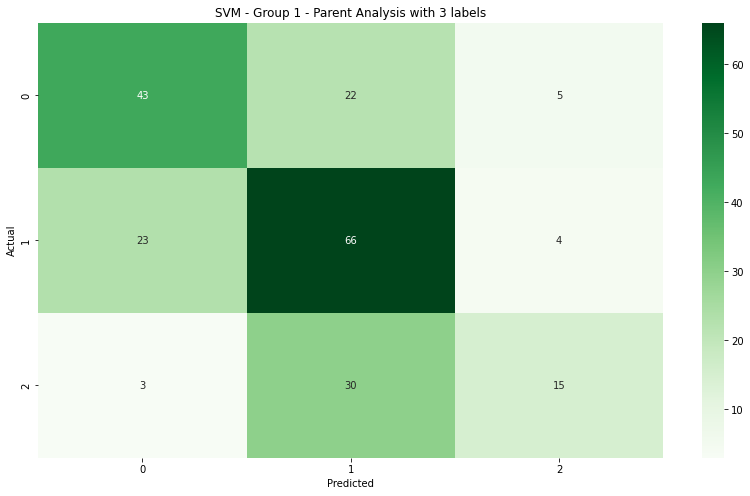



 Aggregate report 
               precision    recall  f1-score   support

           0       0.59      0.55      0.57        49
           1       0.62      0.81      0.70        89
           2       1.00      0.26      0.42        34

    accuracy                           0.63       172
   macro avg       0.73      0.54      0.56       172
weighted avg       0.68      0.63      0.61       172



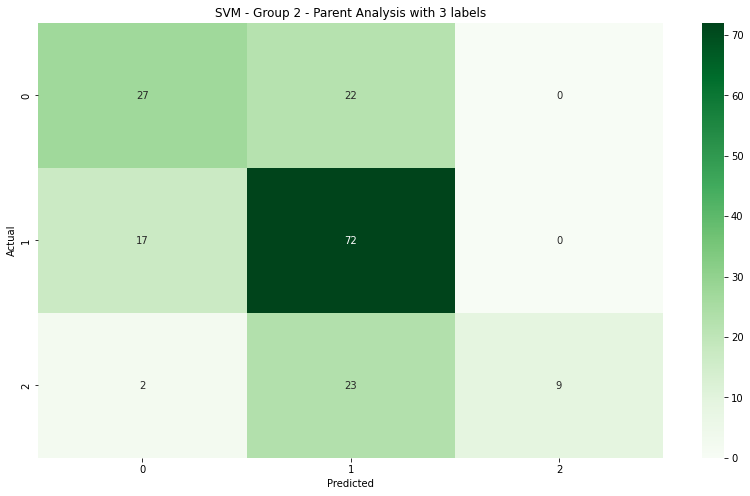



 Aggregate report 
               precision    recall  f1-score   support

           0       0.67      0.95      0.78        19
           1       0.00      0.00      0.00         9
           2       0.69      0.73      0.71        15

    accuracy                           0.67        43
   macro avg       0.45      0.56      0.50        43
weighted avg       0.53      0.67      0.59        43



C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

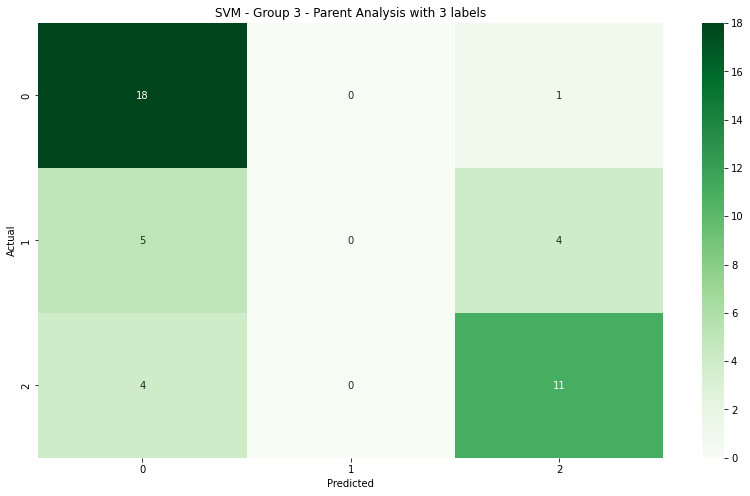

In [151]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non noisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"SVM - Group {i+1} - Parent Analysis with 3 labels", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2'])

**Performance analysis of Combining Labels - Parent Level**

1. There seems to be an improvement in Accuracy and f1 scores after combining labels as can be observed by the confusion matrices above.
2. The model performs significantly better than 4 label baseline at identifying the middle level (label 1) in Groups 1 and 2.  This can be seen in the confusion matrices above.
3. The model continues to perform well for extreme aggression levels (label 1 and label 2) in Group 3.

### Experiment: Class Balancing (with original 4 label)
- Each label has a different number of data points. 
- We balance the classes to have equal data points in each class by resampling
- This is done to avoid sample size biases that might have occurred in the code blocks above.

In [152]:
#check initial size
print(standardized_aggression_df.shape)

(2110, 14)


In [153]:
# Separate classes
level0 = standardized_aggression_df.loc[standardized_aggression_df['segment_label_train'] == 0]
level1 = standardized_aggression_df.loc[standardized_aggression_df['segment_label_train'] == 1]
level2 = standardized_aggression_df.loc[standardized_aggression_df['segment_label_train'] == 2]
level3 = standardized_aggression_df.loc[standardized_aggression_df['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(915, 14)
(612, 14)
(364, 14)
(219, 14)


In [154]:
# Downsample 0 class
level0 = resample(level0, replace=False,n_samples=600)

#level1 is close enough

#Upsample 2 class
level2 = resample(level2, replace=True, n_samples=600)

#Upsample 3 class
level3 = resample(level3, replace=True, n_samples=600)

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

# Combine
standardized_aggression_df_balanced = pd.concat([level0, level1, level2, level3])

(600, 14)
(612, 14)
(600, 14)
(600, 14)


Verify that they have been balanced

In [155]:
print(standardized_aggression_df_balanced.shape)

(2412, 14)


In [156]:
level0 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['segment_label_train'] == 0]
level1 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['segment_label_train'] == 1]
level2 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['segment_label_train'] == 2]
level3 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

#check parent balance

level0 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['parent_label_train'] == 0]
level1 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['parent_label_train'] == 1]
level2 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['parent_label_train'] == 2]
level3 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['parent_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(600, 14)
(612, 14)
(600, 14)
(600, 14)
(362, 14)
(432, 14)
(533, 14)
(1085, 14)


Now we do the same for the remaining two groups, we start with `non noisy`

In [157]:
print(standardized_non_noisy_df.shape)

(1848, 14)


In [158]:
# Separate classes
level0 = standardized_non_noisy_df.loc[standardized_non_noisy_df['segment_label_train'] == 0]
level1 = standardized_non_noisy_df.loc[standardized_non_noisy_df['segment_label_train'] == 1]
level2 = standardized_non_noisy_df.loc[standardized_non_noisy_df['segment_label_train'] == 2]
level3 = standardized_non_noisy_df.loc[standardized_non_noisy_df['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(778, 14)
(593, 14)
(331, 14)
(146, 14)


In [159]:
# Downsample 0 class
level0 = resample(level0, replace=False,n_samples=600)

#level1 is close enough

#Upsample 2 class
level2 = resample(level2, replace=True, n_samples=600)

#Upsample 3 class
level3 = resample(level3, replace=True, n_samples=600)

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

# Combine
standardized_non_noisy_df_balanced = pd.concat([level0, level1, level2, level3])

(600, 14)
(593, 14)
(600, 14)
(600, 14)


In [160]:
print(standardized_non_noisy_df_balanced.shape)

(2393, 14)


In [161]:
level0 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['segment_label_train'] == 0]
level1 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['segment_label_train'] == 1]
level2 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['segment_label_train'] == 2]
level3 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

#check parent label balance

level0 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['parent_label_train'] == 0]
level1 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['parent_label_train'] == 1]
level2 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['parent_label_train'] == 2]
level3 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['parent_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(600, 14)
(593, 14)
(600, 14)
(600, 14)
(331, 14)
(424, 14)
(577, 14)
(1061, 14)


Lastly, we do the same for our last group: `noisy`

In [162]:
print(standardized_noisy_df.shape)

(262, 14)


In [163]:
# Separate classes
level0 = standardized_noisy_df.loc[standardized_noisy_df['segment_label_train'] == 0]
level1 = standardized_noisy_df.loc[standardized_noisy_df['segment_label_train'] == 1]
level2 = standardized_noisy_df.loc[standardized_noisy_df['segment_label_train'] == 2]
level3 = standardized_noisy_df.loc[standardized_noisy_df['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(137, 14)
(19, 14)
(33, 14)
(73, 14)


In [164]:
# Downsample 0 class
level0 = resample(level0, replace=False,n_samples=75)

#Upsample 2 class
level1 = resample(level1, replace=True, n_samples=75)

#Upsample 2 class
level2 = resample(level2, replace=True, n_samples=75)

#level3 close enough

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

# Combine
standardized_noisy_df_balanced = pd.concat([level0, level1, level2, level3])

(75, 14)
(75, 14)
(75, 14)
(73, 14)


Verify

In [165]:
print(standardized_noisy_df_balanced.shape)

(298, 14)


In [166]:
level0 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['segment_label_train'] == 0]
level1 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['segment_label_train'] == 1]
level2 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['segment_label_train'] == 2]
level3 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

#check parent balance 

level0 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['parent_label_train'] == 0]
level1 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['parent_label_train'] == 1]
level2 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['parent_label_train'] == 2]
level3 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['parent_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(75, 14)
(75, 14)
(75, 14)
(73, 14)
(65, 14)
(66, 14)
(27, 14)
(140, 14)


All parents are now more unbalanced, but this should not matter because we are not training on them

We will now rebuild the SVM models after having resampled the data above.

In [167]:
# Separate the 3 groups
data_balanced_np = standardized_aggression_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_np = standardized_aggression_df_balanced['segment_label_train'].to_numpy()
label_balanced_np=label_balanced_np.astype('int')

data_balanced_non_noisy_np = standardized_non_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_non_noisy_np = standardized_non_noisy_df_balanced['segment_label_train'].to_numpy()
label_balanced_non_noisy_np=label_balanced_non_noisy_np.astype('int')

data_balanced_noisy_np = standardized_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_noisy_np = standardized_noisy_df_balanced['segment_label_train'].to_numpy()
label_balanced_noisy_np=label_balanced_noisy_np.astype('int')

C:\Users\samee\AppData\Local\Temp\ipykernel_2380\293252263.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_balanced_np = standardized_aggression_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\samee\AppData\Local\Temp\ipykernel_2380\293252263.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_balanced_non_noisy_np = standardized_non_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\samee\AppData\Local\Temp\ipykernel_2380\293252263.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_balanced_noisy_np = standardized_noisy_df_balanced.drop(["parent_file_trai

#### Hyperparameter Tuning

In [168]:
# hp tuning for all data
quick_parameters = {'C': [1000, 10000,100000], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svc = svm.SVC()
# hyperparameter_tuning(svc, data_balanced_np, label_balanced_np, quick_parameters)

In [169]:
# hp tuning for non-noisy data
quick_parameters = {'C': [100, 1000, 10000], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
# hyperparameter_tuning(svc, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)

In [170]:
# hp tuning for noisy
#up to 10,000 was tested, but it takes a very long time to run, so we dropped it to test the degrees
quick_parameters = {'C': [ 100, 1000], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [2,3,4]}
# hyperparameter_tuning(svc, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

***NOTE: The above code blocks take a lot of time to run because it does a massive GridSearch. We have pasted the final results of the GridSearch below:***

- Group 1 (all data): {'C': 100000, 'gamma': 'auto', 'kernel': 'rbf'}
- Group 2 (non-noisy): {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}
- Group 3 (noisy): {'C': 1000, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}

#### Performance of SVM Model after Resampling - Segment level

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7197240824783305; Accuracy score = 0.7197346600331676 ; Precisison Score = 0.7203096793131306; Recall score = 0.7197346600331676


 Aggregate report 
               precision    recall  f1-score   support

           0       0.62      0.66      0.64       153
           1       0.56      0.53      0.54       145
           2       0.76      0.75      0.76       139
           3       0.92      0.92      0.92       166

    accuracy                           0.72       603
   macro avg       0.71      0.71      0.71       603
weighted avg       0.72      0.72      0.72       603



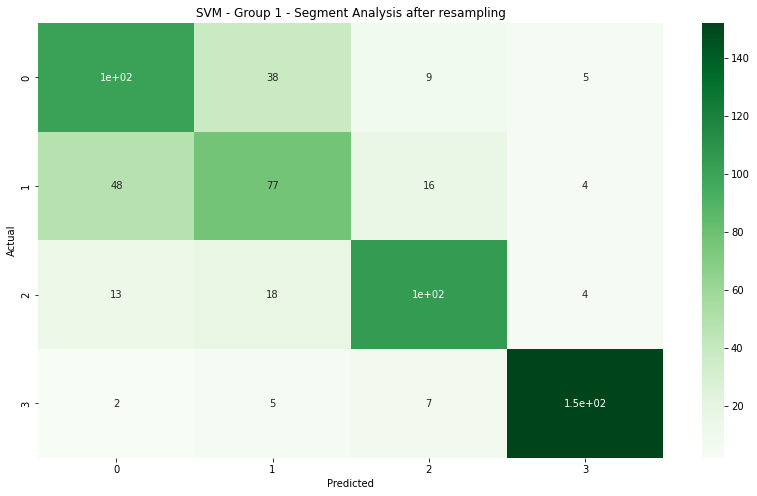

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6746986742601313; Accuracy score = 0.6844741235392321 ; Precisison Score = 0.6708208708641135; Recall score = 0.6844741235392321


 Aggregate report 
               precision    recall  f1-score   support

           0       0.59      0.57      0.58       155
           1       0.55      0.44      0.49       162
           2       0.70      0.80      0.75       137
           3       0.86      0.97      0.91       145

    accuracy                           0.68       599
   macro avg       0.68      0.70      0.68       599
weighted avg       0.67      0.68      0.67       599



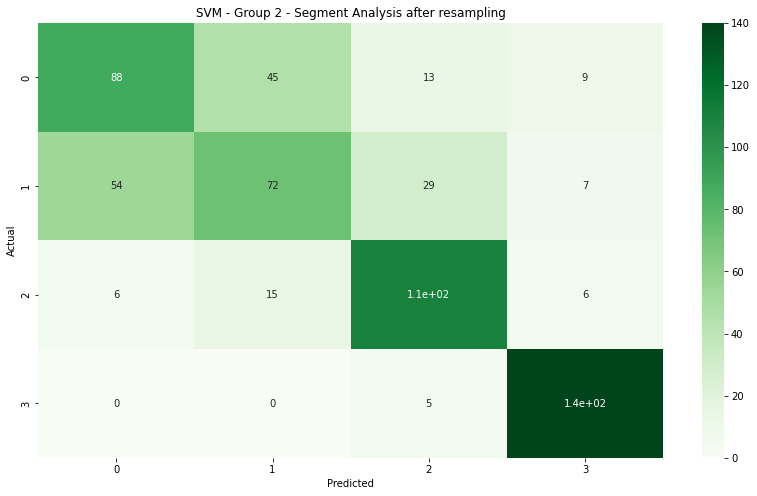

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7088110599078341; Accuracy score = 0.72 ; Precisison Score = 0.718982456140351; Recall score = 0.72


 Aggregate report 
               precision    recall  f1-score   support

           0       0.75      0.47      0.58        19
           1       0.84      1.00      0.91        16
           2       0.70      0.81      0.75        26
           3       0.57      0.57      0.57        14

    accuracy                           0.72        75
   macro avg       0.72      0.71      0.70        75
weighted avg       0.72      0.72      0.71        75



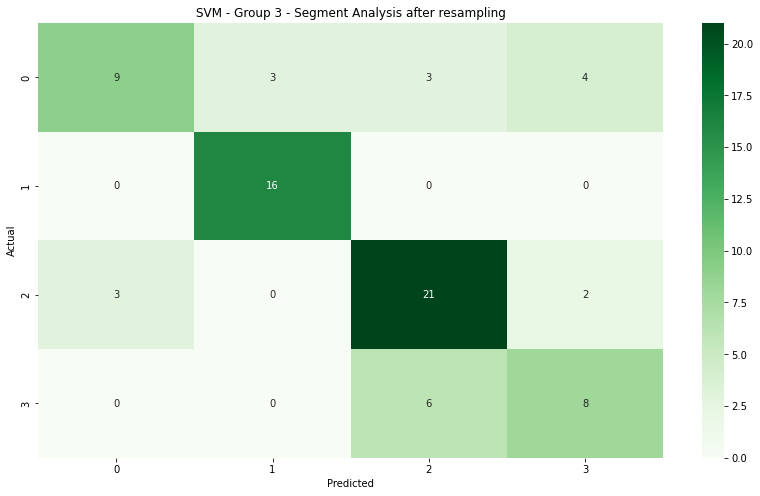

In [171]:
#lst_data_np = [data_np, data_non_noisy_np, data_noisy_np]
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
kernel = ['rbf','rbf','poly']
gamma = ['auto', 'scale', 'auto']
c = [100000, 1000, 1000]

for i in range(3):
    svm_model = svm.SVC(kernel=kernel[i], gamma=gamma[i], C=c[i], degree= 3)
    actual, predicted, X_test_list[i] = run_model(svm_model, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"SVM - Group {i+1} - Segment Analysis after resampling", actual, predicted, ['0', '1', '2', '3'])

#### Performance of SVM Model after Resampling - Parent level



 Aggregate report 
               precision    recall  f1-score   support

           0       0.62      0.58      0.60        65
           1       0.48      0.48      0.48        46
           2       0.62      0.67      0.65        46
           3       0.83      0.83      0.83        53

    accuracy                           0.64       210
   macro avg       0.64      0.64      0.64       210
weighted avg       0.64      0.64      0.64       210



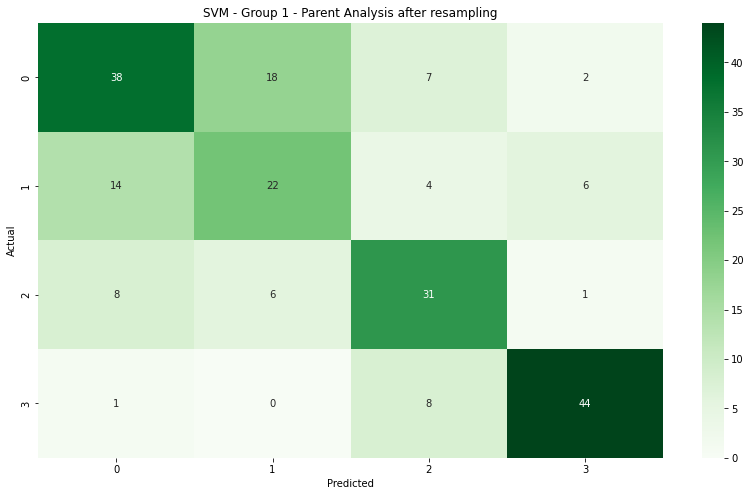



 Aggregate report 
               precision    recall  f1-score   support

           0       0.61      0.48      0.53        48
           1       0.57      0.49      0.53        49
           2       0.65      0.75      0.70        48
           3       0.72      0.92      0.80        36

    accuracy                           0.64       181
   macro avg       0.64      0.66      0.64       181
weighted avg       0.63      0.64      0.63       181



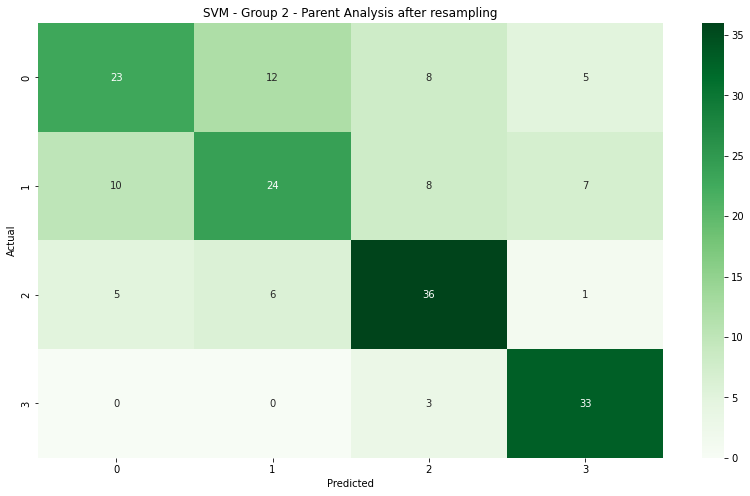



 Aggregate report 
               precision    recall  f1-score   support

           0       0.83      0.36      0.50        14
           1       0.57      0.80      0.67         5
           2       0.18      0.50      0.27         4
           3       0.62      0.57      0.59        14

    accuracy                           0.51        37
   macro avg       0.55      0.56      0.51        37
weighted avg       0.65      0.51      0.53        37



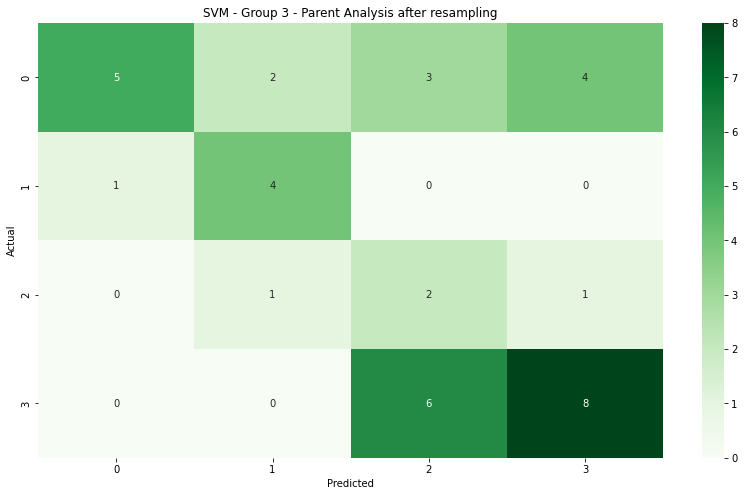

In [172]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"SVM - Group {i+1} - Parent Analysis after resampling", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

#### Results after resampling data

- Groups 1 and 2 have about 5-10% increase in terms of accuracy in both the parent and segment analysis.
- Group 3 does not have such substantial improvements.

### Experiment: Combining Levels + Class Balancing 
- Next, we resample the previously created `merged_labels` data. 
- Label 2 was merged to label 1 for both parent and segment analysis.
- Label 3 was re-encoded as label 2 for both parent and segment analysis. 

**Group 1 - All data**

In [173]:
print(standardized_aggression_mergedlabels_df.shape)

(2110, 14)


In [174]:
# Separate classes
level0 = standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['segment_label_train'] == 0]
level1 = standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['segment_label_train'] == 1]
level2 = standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(915, 14)
(976, 14)
(219, 14)


In [175]:
#level0 close enough

#level1 close enough

#Upsample 2 class
level2 = resample(level2, replace=True, n_samples=900)

print(level0.shape)
print(level1.shape)
print(level2.shape)

# Combine
standardized_aggression_mergedlabels_df_balanced = pd.concat([level0, level1, level2])

(915, 14)
(976, 14)
(900, 14)


In [176]:
print(standardized_aggression_mergedlabels_df_balanced.shape)

(2791, 14)


In [177]:
level0 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['segment_label_train'] == 0]
level1 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['segment_label_train'] == 1]
level2 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

#check parent label balance

level0 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['parent_label_train'] == 0]
level1 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['parent_label_train'] == 1]
level2 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['parent_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(915, 14)
(976, 14)
(900, 14)
(536, 14)
(956, 14)
(1299, 14)


Group 2 - Non noisy

In [178]:
print(standardized_mergedlabels_non_noisy_df.shape)

(1848, 14)


In [179]:
# Separate classes
level0 = standardized_mergedlabels_non_noisy_df.loc[standardized_mergedlabels_non_noisy_df['segment_label_train'] == 0]
level1 = standardized_mergedlabels_non_noisy_df.loc[standardized_mergedlabels_non_noisy_df['segment_label_train'] == 1]
level2 = standardized_mergedlabels_non_noisy_df.loc[standardized_mergedlabels_non_noisy_df['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(778, 14)
(924, 14)
(146, 14)


In [180]:
#level0 close enough

#level1 close enough
# Downsample 0 class
level1 = resample(level1, replace=False,n_samples=775)

#Upsample 2 class
level2 = resample(level2, replace=True, n_samples=775)

print(level0.shape)
print(level1.shape)
print(level2.shape)

# Combine
standardized_mergedlabels_non_noisy_df_balanced = pd.concat([level0, level1, level2])

(778, 14)
(775, 14)
(775, 14)


In [181]:
print(standardized_mergedlabels_non_noisy_df_balanced.shape)

(2328, 14)


In [182]:
level0 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['segment_label_train'] == 0]
level1 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['segment_label_train'] == 1]
level2 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

#check parent label balance

level0 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['parent_label_train'] == 0]
level1 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['parent_label_train'] == 1]
level2 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['parent_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(778, 14)
(775, 14)
(775, 14)
(418, 14)
(815, 14)
(1095, 14)


Group 3 - Noisy

In [183]:
print(standardized_mergedlabels_noisy_df.shape)

(262, 14)


In [184]:
# Separate classes
level0 = standardized_mergedlabels_noisy_df.loc[standardized_mergedlabels_noisy_df['segment_label_train'] == 0]
level1 = standardized_mergedlabels_noisy_df.loc[standardized_mergedlabels_noisy_df['segment_label_train'] == 1]
level2 = standardized_mergedlabels_noisy_df.loc[standardized_mergedlabels_noisy_df['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(137, 14)
(52, 14)
(73, 14)


In [185]:
# Downsample 0 class
level0 = resample(level0, replace=False,n_samples=75)

#Upsample 2 class
level1 = resample(level1, replace=True, n_samples=75)

#level3 is close enough

print(level0.shape)
print(level1.shape)
print(level2.shape)

# Combine
standardized_mergedlabels_noisy_df_balanced = pd.concat([level0, level1, level2])

(75, 14)
(75, 14)
(73, 14)


In [186]:
print(standardized_mergedlabels_noisy_df_balanced.shape)

(223, 14)


In [187]:
level0 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['segment_label_train'] == 0]
level1 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['segment_label_train'] == 1]
level2 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

#check parent label balance

level0 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['parent_label_train'] == 0]
level1 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['parent_label_train'] == 1]
level2 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['parent_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(75, 14)
(75, 14)
(73, 14)
(61, 14)
(48, 14)
(114, 14)


Rebuild the svm models with the updated resampled data and merged labels

In [188]:
data_balanced_merged_np = standardized_aggression_mergedlabels_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_merged_np = standardized_aggression_mergedlabels_df_balanced['segment_label_train'].to_numpy()
label_balanced_merged_np=label_balanced_merged_np.astype('int')

data_balanced_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df_balanced['segment_label_train'].to_numpy()
label_balanced_merged_non_noisy_np=label_balanced_merged_non_noisy_np.astype('int')

data_balanced_merged_noisy_np = standardized_mergedlabels_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_merged_noisy_np = standardized_mergedlabels_noisy_df_balanced['segment_label_train'].to_numpy()
label_balanced_merged_noisy_np=label_balanced_merged_noisy_np.astype('int')

C:\Users\samee\AppData\Local\Temp\ipykernel_2380\4173322112.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_balanced_merged_np = standardized_aggression_mergedlabels_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\samee\AppData\Local\Temp\ipykernel_2380\4173322112.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_balanced_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\samee\AppData\Local\Temp\ipykernel_2380\4173322112.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_balanced_merged_noisy_np = stand

In [189]:
# original_parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': ['scale', 'auto'],
#                    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [1,2,3,4,5,6]}

quick_parameters = {'C': [0.01, 0.1, 1, 10], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svc = svm.SVC()
#hyperparameter_tuning(svc, data_balanced_merged_np, label_balanced_merged_np, quick_parameters)
#hyperparameter_tuning(svc, data_balanced_merged_non_noisy_np, label_balanced_merged_non_noisy_np, quick_parameters)
#hyperparameter_tuning(svc, data_balanced_merged_noisy_np, label_balanced_merged_noisy_np, quick_parameters)

NOTE: The above code block takes a lot of time to run because it does a massive GridSearch. We have pasted the final results of the GridSearch below.

***Hyperparameter Tuning Results:***
- Group 1 (all data): {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
- Group 2 (non-noisy): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
- Group 3 (noisy): {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

#### Performance of SVM Combining labels after Class Balancing - Segment level

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.735070460381225; Accuracy score = 0.7378223495702005 ; Precisison Score = 0.7352158483676419; Recall score = 0.7378223495702005


 Aggregate report 
               precision    recall  f1-score   support

           0       0.75      0.69      0.72       222
           1       0.67      0.64      0.65       246
           2       0.79      0.89      0.84       230

    accuracy                           0.74       698
   macro avg       0.74      0.74      0.74       698
weighted avg       0.74      0.74      0.74       698



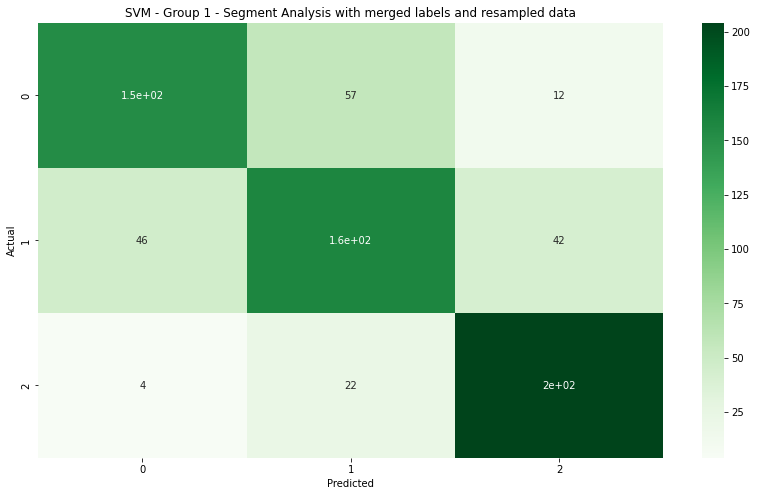

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7133110474772518; Accuracy score = 0.7164948453608248 ; Precisison Score = 0.7119646380554182; Recall score = 0.7164948453608248


 Aggregate report 
               precision    recall  f1-score   support

           0       0.73      0.70      0.71       201
           1       0.62      0.58      0.60       198
           2       0.80      0.88      0.84       183

    accuracy                           0.72       582
   macro avg       0.71      0.72      0.72       582
weighted avg       0.71      0.72      0.71       582



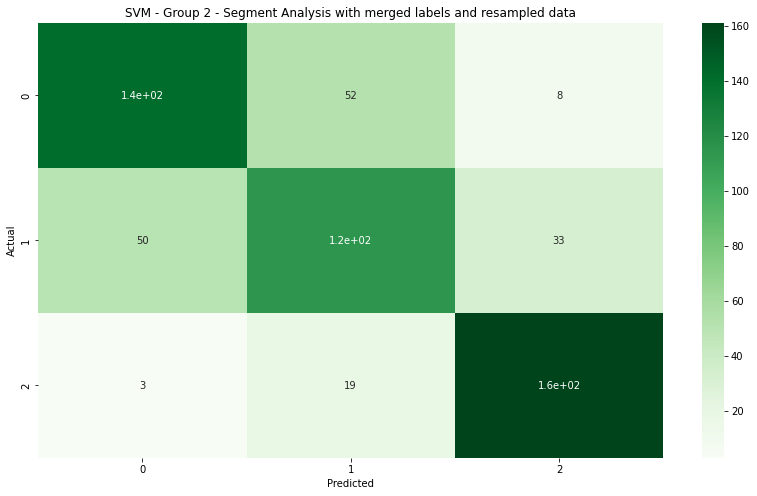

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6401605307135262; Accuracy score = 0.6428571428571429 ; Precisison Score = 0.6422309833024118; Recall score = 0.6428571428571429


 Aggregate report 
               precision    recall  f1-score   support

           0       0.68      0.75      0.71        20
           1       0.64      0.53      0.58        17
           2       0.60      0.63      0.62        19

    accuracy                           0.64        56
   macro avg       0.64      0.64      0.64        56
weighted avg       0.64      0.64      0.64        56



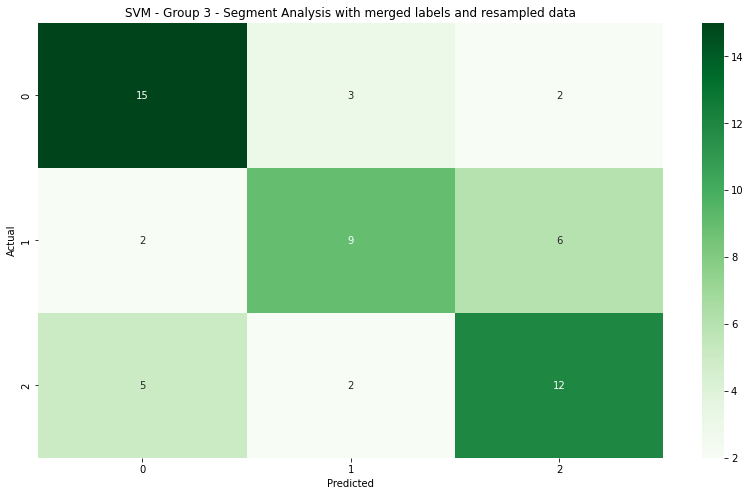

In [190]:
lst_label_np = [label_balanced_merged_np, label_balanced_merged_non_noisy_np, label_balanced_merged_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_mergedlabels_df_balanced, standardized_mergedlabels_non_noisy_df_balanced, standardized_mergedlabels_noisy_df_balanced]
X_test_list = [None,None,None]
gamma = ['auto', 'scale', 'auto']

for i in range(3):
    svm_model = svm.SVC(kernel='rbf', gamma=gamma[i], C=10)
    actual, predicted, X_test_list[i] = run_model(svm_model, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"SVM - Group {i+1} - Segment Analysis with merged labels and resampled data", actual, predicted, ['0', '1', '2'])

#### Performance of SVM Combining labels after Class Balancing - Parent level



 Aggregate report 
               precision    recall  f1-score   support

           0       0.69      0.61      0.65        77
           1       0.65      0.65      0.65        93
           2       0.58      0.69      0.63        49

    accuracy                           0.64       219
   macro avg       0.64      0.65      0.64       219
weighted avg       0.65      0.64      0.64       219



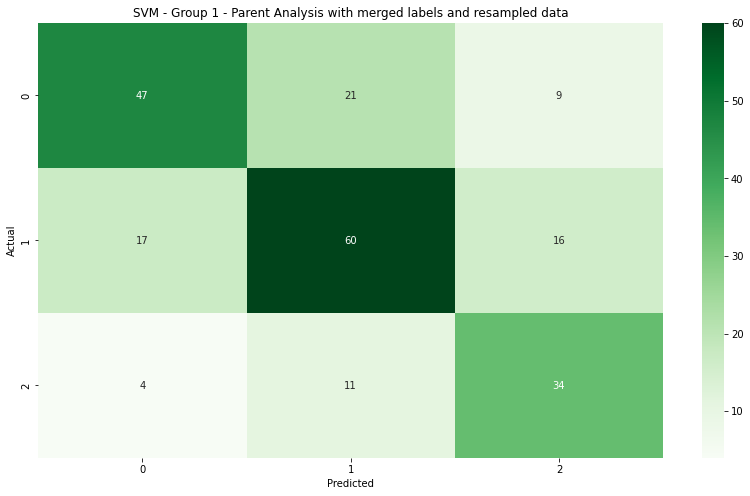



 Aggregate report 
               precision    recall  f1-score   support

           0       0.60      0.64      0.62        53
           1       0.68      0.61      0.65        85
           2       0.57      0.64      0.61        42

    accuracy                           0.63       180
   macro avg       0.62      0.63      0.62       180
weighted avg       0.63      0.63      0.63       180



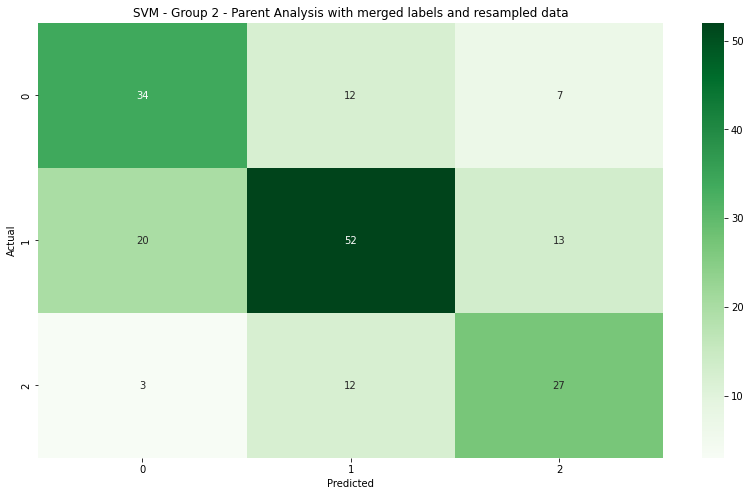



 Aggregate report 
               precision    recall  f1-score   support

           0       0.83      0.71      0.77        14
           1       0.25      0.67      0.36         3
           2       0.85      0.69      0.76        16

    accuracy                           0.70        33
   macro avg       0.64      0.69      0.63        33
weighted avg       0.79      0.70      0.73        33



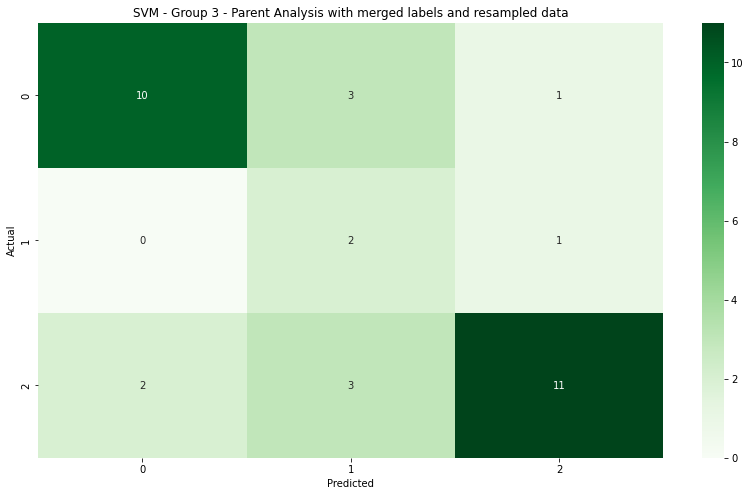

In [191]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"SVM - Group {i+1} - Parent Analysis with merged labels and resampled data", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2']) 

### Experiment: Combine Labels for Binary Classifications of Noisy data (Group 3)

Perhaps for Group 3 (noisy) because everything is so loud that we can only seem to get binary classification. Therefore, we will now merge labels for just group 3 (noisy data)
- Label 1 is merged with label 0
- Labels 2 and 3 are combined and re labelled as label 1

In [192]:
standardized_aggression_binary_df = standardized_aggression_df.copy()
# Merge segment level labels
standardized_binary_noisy_df = standardized_aggression_binary_df.loc[standardized_aggression_binary_df['noisy_train'] == 1]
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 1, 'segment_label_train' ] = 0
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 2, 'segment_label_train'] = 1
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 3, 'segment_label_train'] = 1
# Merge parent level labels
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['parent_label_train'] == 1, 'parent_label_train'] = 0
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['parent_label_train'] == 3, 'parent_label_train'] = 1
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['parent_label_train'] == 2, 'parent_label_train'] = 1

print(standardized_binary_noisy_df['segment_label_train'].unique())
print(standardized_binary_noisy_df['parent_label_train'].unique())

C:\Users\samee\AppData\Local\Temp\ipykernel_2380\778271495.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 1, 'segment_label_train' ] = 0
C:\Users\samee\AppData\Local\Temp\ipykernel_2380\778271495.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 2, 'segment_label_train'] = 1
C:\Users\samee\AppData\Local\Temp\ipykernel_2380\778271495.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

[0 1]
[0 1]


In [193]:
data_binary_noisy_np = standardized_binary_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_binary_noisy_np = standardized_binary_noisy_df['segment_label_train'].to_numpy()
label_binary_noisy_np=label_binary_noisy_np.astype('int')

C:\Users\samee\AppData\Local\Temp\ipykernel_2380\524940715.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_binary_noisy_np = standardized_binary_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()


In [194]:
quick_parameters = {'C': [ 0.001, 0.01, 0.1, 1, 10, 100], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svc = svm.SVC()
#hyperparameter_tuning(svc, data_binary_noisy_np, label_binary_noisy_np, quick_parameters)

NOTE: The above code block takes a lot of time to run because it does a massive GridSearch. We have pasted the final results of the GridSearch below.
***Hyperparameter Tuning Results:.***
- Group 3 (noisy): {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

In [195]:
# Separate classes
level0 = standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 0]
level1 = standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 1]

print(level0.shape)
print(level1.shape)

(156, 14)
(106, 14)


Data is already pretty balanced, no need to resample it

#### SVM - Segment Analysis for Group 3 with 2 labels

#### Performance of SVM for Noisy Data (Group 3) with Binary labels - Segment level

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.807591706539075; Accuracy score = 0.803030303030303 ; Precisison Score = 0.8566454991087344; Recall score = 0.803030303030303


 Aggregate report 
               precision    recall  f1-score   support

           0       0.97      0.72      0.83        43
           1       0.65      0.96      0.77        23

    accuracy                           0.80        66
   macro avg       0.81      0.84      0.80        66
weighted avg       0.86      0.80      0.81        66



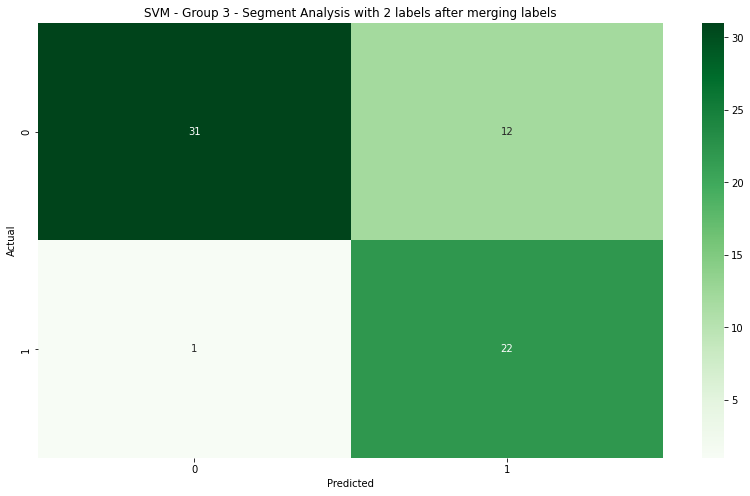

In [196]:
label = 'segment_label_train'
X_test_list = [None]

svm_model = svm.SVC(kernel='linear', gamma='scale', C=0.1)
actual, predicted, X_test_list[0] = run_model(svm_model, standardized_binary_noisy_df,  label_binary_noisy_np,label_name=label)

confusion_matrix_graph(f"SVM - Group 3 - Segment Analysis with 2 labels after merging labels", actual, predicted, ['0', '1'])

#### Performance of SVM for Noisy Data (Group 3) with Binary labels - Parent level



 Aggregate report 
               precision    recall  f1-score   support

           0       0.94      0.68      0.79        22
           1       0.68      0.94      0.79        16

    accuracy                           0.79        38
   macro avg       0.81      0.81      0.79        38
weighted avg       0.83      0.79      0.79        38



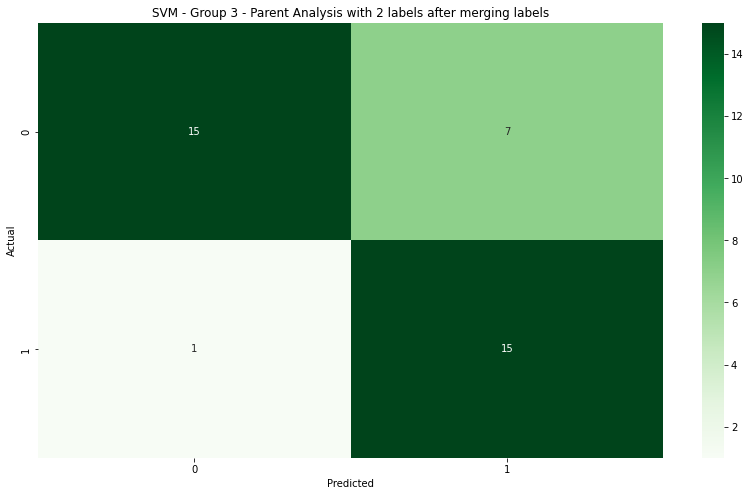

In [197]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non noisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"SVM - Group 3 - Parent Analysis with 2 labels after merging labels", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1'])


#### Results for Binary Classification of Group 3 (Noisy) with above modified SVM models:
- For Group 3 (noisy data) middle levels cannot be teased out with the background sound and overlapping voices

### Conclusions based on all the SVM models ran above:

- Combining/merging labels does yields only slightly better models (approx 8%)
- However, merging the lables deviates our focus from our original research question
- Therefore, it is more interesting to classify both noisy and non-noisy with the same levels and without merging the labels.
- ***Hence, we will select the orignal classification of 4 labels with the balanced data, in the all the various models below***

# Comparative Models

### KNN

In [198]:
knn = KNeighborsClassifier()
k_range = list(range(1, 31))

#### Hyperparameter Tuning for Group 1 (all data) KNN

In [199]:
# original_parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': ['scale', 'auto'],
#                    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [1,2,3,4,5,6]}

quick_parameters = {'n_neighbors':k_range, 'weights': ['uniform','distance'],
                    'metric': ['euclidean', 'manhattan'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'leaf_size':k_range}
#hyperparameter_tuning(knn, data_balanced_np, label_balanced_np, quick_parameters)

#### Hyperparameter Tuning for Group 2 (non noisy) KNN

In [200]:
quick_parameters = {'n_neighbors':k_range, 'weights': ['uniform','distance'],
                    'metric': ['euclidean', 'manhattan'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'leaf_size':k_range}
#hyperparameter_tuning(knn, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)

#### Hyperparameter Tuning for Group 3 (noisy) KNN

In [201]:
#up to 10,000 was tested, but it takes a very long time to run, so we dropped it to test the degrees
quick_parameters = {'n_neighbors':k_range, 'weights': ['uniform','distance'],
                    'metric': ['euclidean', 'manhattan'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'leaf_size':k_range}
#hyperparameter_tuning(knn, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

***NOTE: The above code blocks take a lot of time to run because it does a massive GridSearch. We have pasted the final results of the GridSearch below:***

- Group 1: {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
- Group 2: {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
- Group 3: {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}

#### Performance of kNN - Segment level

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6930433201711895; Accuracy score = 0.7014925373134329 ; Precisison Score = 0.6920950254863261; Recall score = 0.7014925373134329


 Aggregate report 
               precision    recall  f1-score   support

           0       0.67      0.56      0.61       153
           1       0.59      0.52      0.55       152
           2       0.74      0.80      0.77       170
           3       0.79      0.95      0.86       128

    accuracy                           0.70       603
   macro avg       0.69      0.71      0.70       603
weighted avg       0.69      0.70      0.69       603



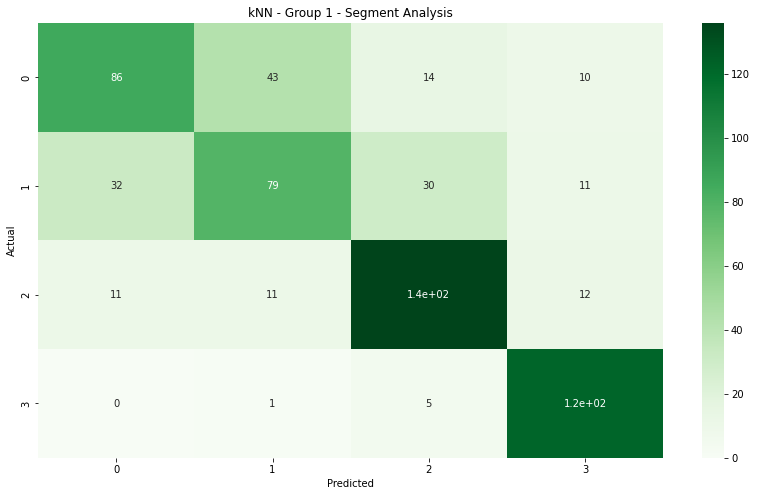

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7112327107274106; Accuracy score = 0.7195325542570952 ; Precisison Score = 0.7116855934071282; Recall score = 0.7195325542570952


 Aggregate report 
               precision    recall  f1-score   support

           0       0.64      0.56      0.59       149
           1       0.62      0.52      0.57       154
           2       0.69      0.86      0.77       143
           3       0.89      0.95      0.92       153

    accuracy                           0.72       599
   macro avg       0.71      0.72      0.71       599
weighted avg       0.71      0.72      0.71       599



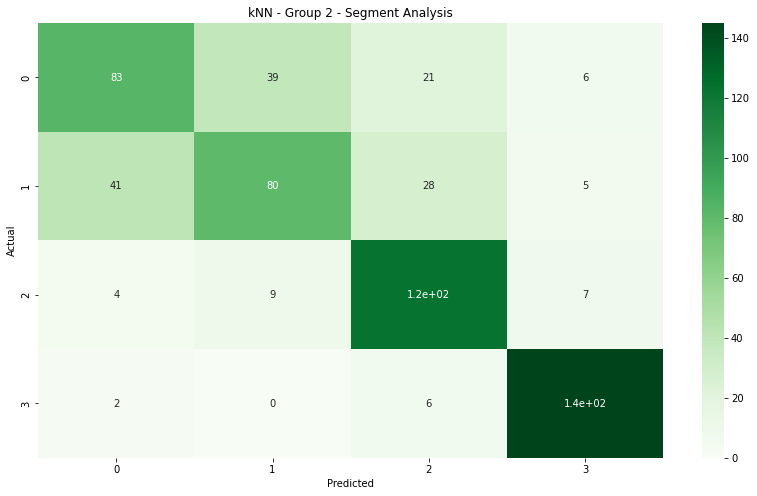

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.8141150703175327; Accuracy score = 0.8133333333333334 ; Precisison Score = 0.8277022860180754; Recall score = 0.8133333333333334


 Aggregate report 
               precision    recall  f1-score   support

           0       0.89      0.71      0.79        24
           1       0.87      1.00      0.93        13
           2       0.86      0.83      0.84        23
           3       0.63      0.80      0.71        15

    accuracy                           0.81        75
   macro avg       0.81      0.83      0.82        75
weighted avg       0.83      0.81      0.81        75



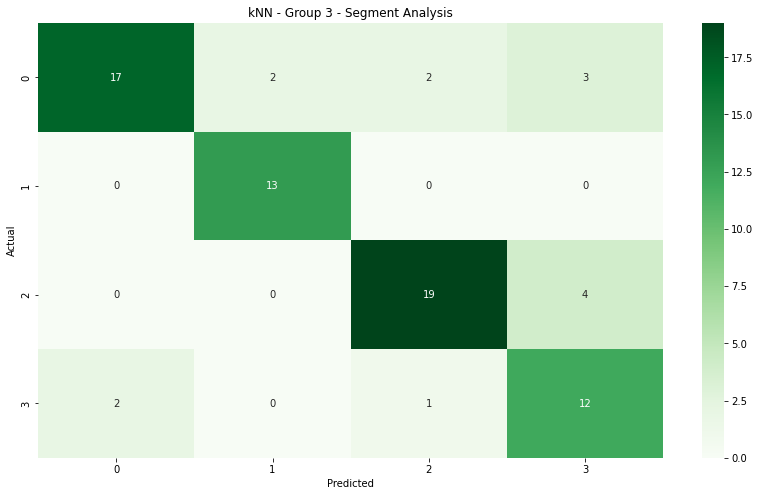

In [202]:
#lst_data_np = [data_np, data_non_noisy_np, data_noisy_np]
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
metric = ['manhattan','manhattan','euclidean']

for i in range(3):
    knn = KNeighborsClassifier(n_neighbors= 1,algorithm='auto',leaf_size= 1, metric= metric[i],weights='uniform')
    actual, predicted, X_test_list[i] = run_model(knn, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"kNN - Group {i+1} - Segment Analysis", actual, predicted, ['0', '1', '2', '3'])

#### Performance of kNN - Parent level



 Aggregate report 
               precision    recall  f1-score   support

           0       0.74      0.40      0.52        57
           1       0.50      0.55      0.52        49
           2       0.61      0.69      0.65        49
           3       0.67      0.86      0.75        49

    accuracy                           0.62       204
   macro avg       0.63      0.63      0.61       204
weighted avg       0.63      0.62      0.61       204



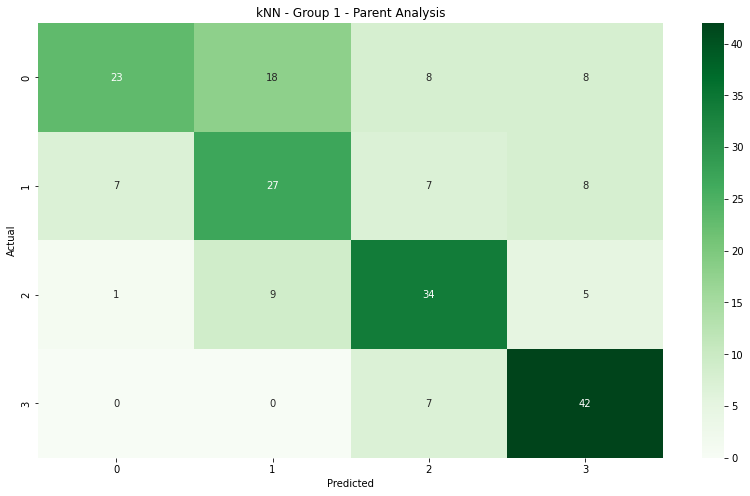



 Aggregate report 
               precision    recall  f1-score   support

           0       0.59      0.46      0.52        50
           1       0.50      0.43      0.47        46
           2       0.52      0.62      0.57        48
           3       0.66      0.78      0.72        37

    accuracy                           0.56       181
   macro avg       0.57      0.58      0.57       181
weighted avg       0.56      0.56      0.56       181



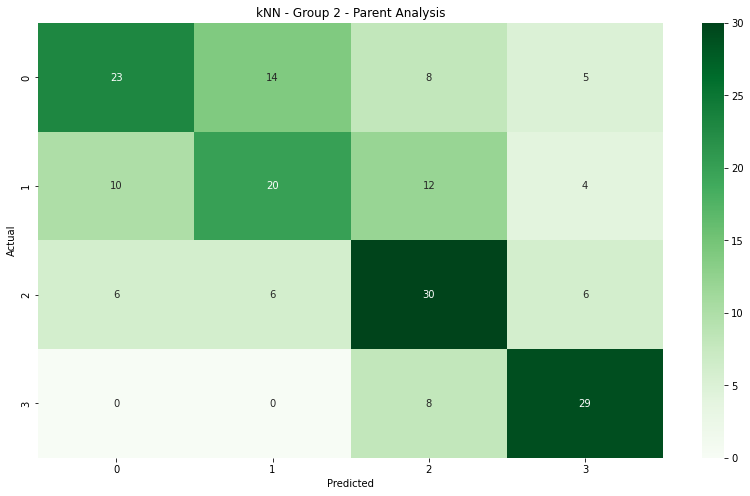



 Aggregate report 
               precision    recall  f1-score   support

           0       0.80      0.62      0.70        13
           1       0.57      0.67      0.62         6
           2       0.40      0.67      0.50         3
           3       0.77      0.77      0.77        13

    accuracy                           0.69        35
   macro avg       0.64      0.68      0.65        35
weighted avg       0.72      0.69      0.69        35



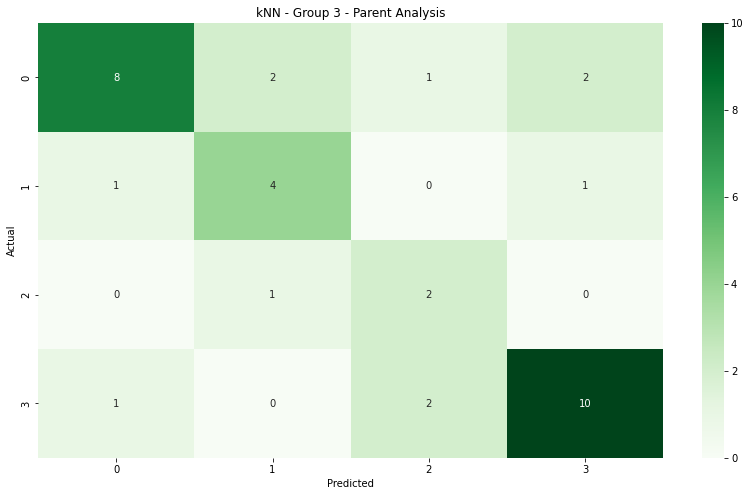

In [203]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"kNN - Group {i+1} - Parent Analysis", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])  

## Tree based models

### Decision Tree

In [204]:
quick_parameters = {'criterion' : ['gini', 'entropy'], 'max_depth' : [2,4,6,8,10,12,14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36]}

dtree = DecisionTreeClassifier()
# hyperparameter_tuning(dtree, data_balanced_np, label_balanced_np, quick_parameters)
# hyperparameter_tuning(dtree, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)
# hyperparameter_tuning(dtree, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

NOTE: The above code block takes a lot of time to run because it does a massive GridSearch. We have pasted the final results of the GridSearch below:

***Hyperparameter Tuning Results:***
- Group 1 (all data): {'criterion': 'entropy', 'max_depth': 30}
- Group 2 (non-noisy): {'criterion': 'entropy', 'max_depth': 20}
- Group 3 (noisy): {'criterion': 'gini', 'max_depth': 18}

#### Performance of Decision Tree - Segment level

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.667991317602156; Accuracy score = 0.6749585406301825 ; Precisison Score = 0.6716920587006114; Recall score = 0.6749585406301825


 Aggregate report 
               precision    recall  f1-score   support

           0       0.57      0.58      0.58       138
           1       0.63      0.47      0.54       169
           2       0.63      0.77      0.69       146
           3       0.85      0.91      0.88       150

    accuracy                           0.67       603
   macro avg       0.67      0.68      0.67       603
weighted avg       0.67      0.67      0.67       603



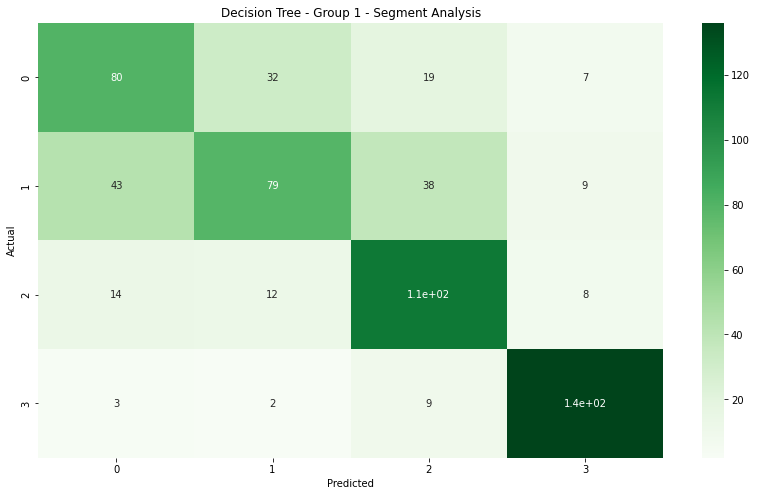

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6630301007583719; Accuracy score = 0.679465776293823 ; Precisison Score = 0.6589814845778175; Recall score = 0.679465776293823


 Aggregate report 
               precision    recall  f1-score   support

           0       0.61      0.53      0.57       156
           1       0.51      0.38      0.44       146
           2       0.71      0.82      0.76       152
           3       0.81      0.99      0.89       145

    accuracy                           0.68       599
   macro avg       0.66      0.68      0.66       599
weighted avg       0.66      0.68      0.66       599



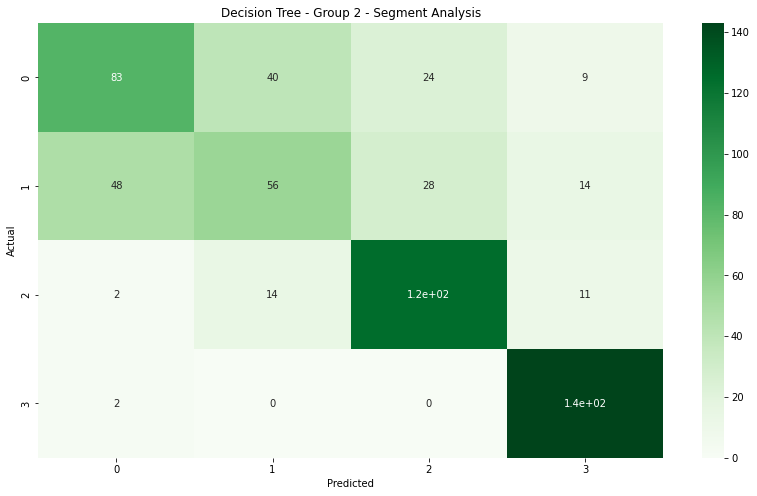

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6750827443421147; Accuracy score = 0.6933333333333334 ; Precisison Score = 0.7040992196209588; Recall score = 0.6933333333333334


 Aggregate report 
               precision    recall  f1-score   support

           0       0.80      0.42      0.55        19
           1       0.77      1.00      0.87        20
           2       0.61      0.82      0.70        17
           3       0.62      0.53      0.57        19

    accuracy                           0.69        75
   macro avg       0.70      0.69      0.67        75
weighted avg       0.70      0.69      0.68        75



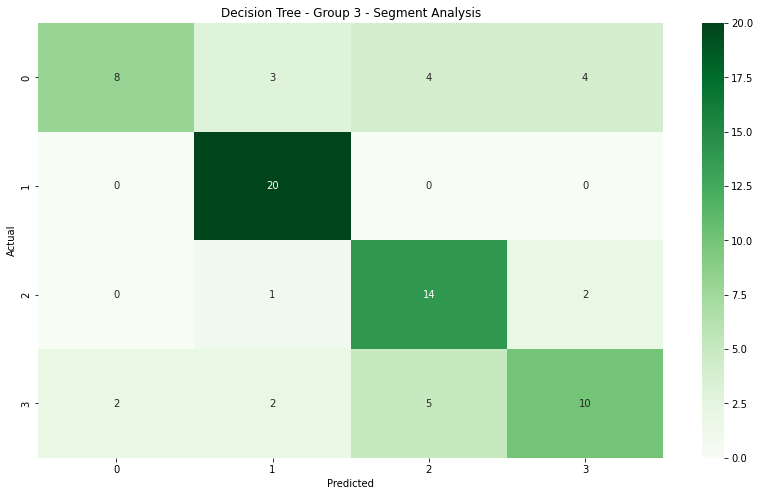

In [205]:
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
criterion = ['entropy','entropy','gini']
max_depth = [30,20,18]

for i in range(3):
    dtree = DecisionTreeClassifier(criterion=criterion[i], max_depth=max_depth[i])
    actual, predicted, X_test_list[i] = run_model(dtree, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"Decision Tree - Group {i+1} - Segment Analysis", actual, predicted, ['0', '1', '2', '3'])

#### Performance of Decision Tree - Parent level



 Aggregate report 
               precision    recall  f1-score   support

           0       0.75      0.51      0.61        59
           1       0.49      0.49      0.49        47
           2       0.48      0.65      0.55        46
           3       0.72      0.75      0.74        52

    accuracy                           0.60       204
   macro avg       0.61      0.60      0.60       204
weighted avg       0.62      0.60      0.60       204



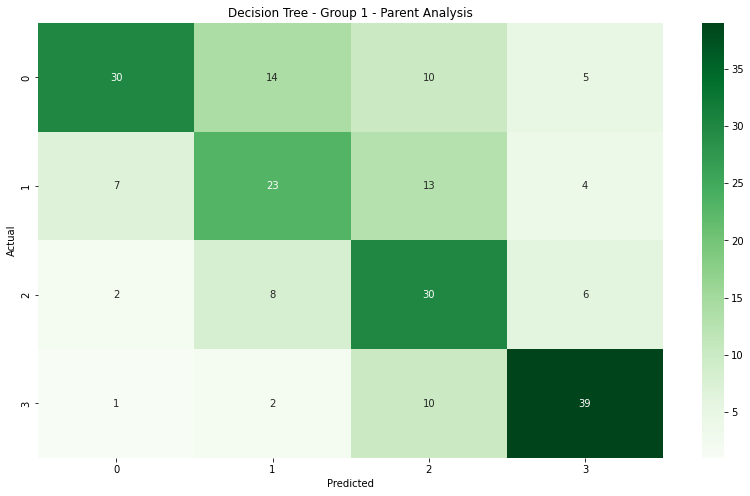



 Aggregate report 
               precision    recall  f1-score   support

           0       0.50      0.29      0.37        48
           1       0.46      0.36      0.40        45
           2       0.61      0.85      0.71        46
           3       0.63      0.82      0.72        40

    accuracy                           0.57       179
   macro avg       0.55      0.58      0.55       179
weighted avg       0.55      0.57      0.54       179



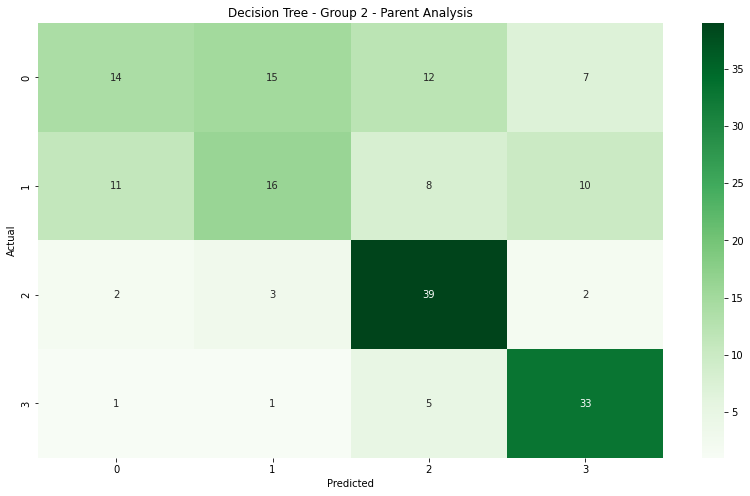



 Aggregate report 
               precision    recall  f1-score   support

           0       0.57      0.36      0.44        11
           1       0.50      0.71      0.59         7
           2       0.38      0.60      0.46         5
           3       0.75      0.64      0.69        14

    accuracy                           0.57        37
   macro avg       0.55      0.58      0.55        37
weighted avg       0.60      0.57      0.57        37



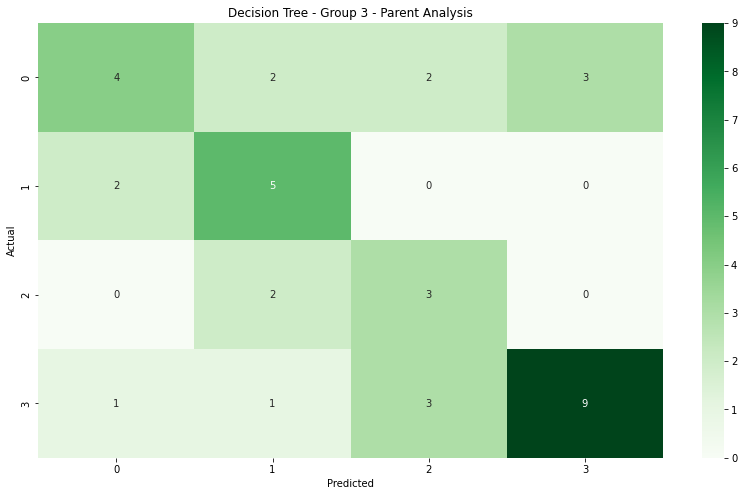

In [206]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"Decision Tree - Group {i+1} - Parent Analysis", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])


## Random Forest

- `random search` has been used to speed up the grid search (was taking 12h+)

In [207]:
def hyperparameter_tuning_random(ml_model, data, label, parameters):
    clf = RandomizedSearchCV(ml_model, parameters, n_iter = 50, refit=True, verbose=0, scoring='f1_weighted', n_jobs=-1, error_score='raise')
    clf.fit(data, label)
    print(clf.best_params_)

In [208]:
quick_parameters = {
  'n_estimators' : [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
  'max_features' : ['auto', 'sqrt'],
  'max_depth' : [int(x) for x in np.linspace(10, 150, num = 11)],
  'min_samples_split' : [2, 5, 10, 15],
  'min_samples_leaf' : [1, 2, 4],
  'bootstrap' : [True, False],
}

rtree = RandomForestClassifier()
# hyperparameter_tuning_random(rtree, data_balanced_np, label_balanced_np, quick_parameters)
# hyperparameter_tuning_random(rtree, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)
# hyperparameter_tuning_random(rtree, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

NOTE: The above code block takes a lot of time to run because it does a massive GridSearch. We have pasted the final results of the GridSearch below for all three groups.

***Hyper Parameter Tuning Results***

Group 1 (all data): {'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 122, 'bootstrap': False}

Group 2 (non noisy): {'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 38, 'bootstrap': False}

Group 3 (noisy): {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}

#### Performance of Random Forest - Segment Level

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7143259883489171; Accuracy score = 0.7197346600331676 ; Precisison Score = 0.7135376423261902; Recall score = 0.7197346600331676


 Aggregate report 
               precision    recall  f1-score   support

           0       0.69      0.58      0.63       154
           1       0.59      0.57      0.58       151
           2       0.75      0.78      0.76       140
           3       0.82      0.94      0.88       158

    accuracy                           0.72       603
   macro avg       0.71      0.72      0.71       603
weighted avg       0.71      0.72      0.71       603



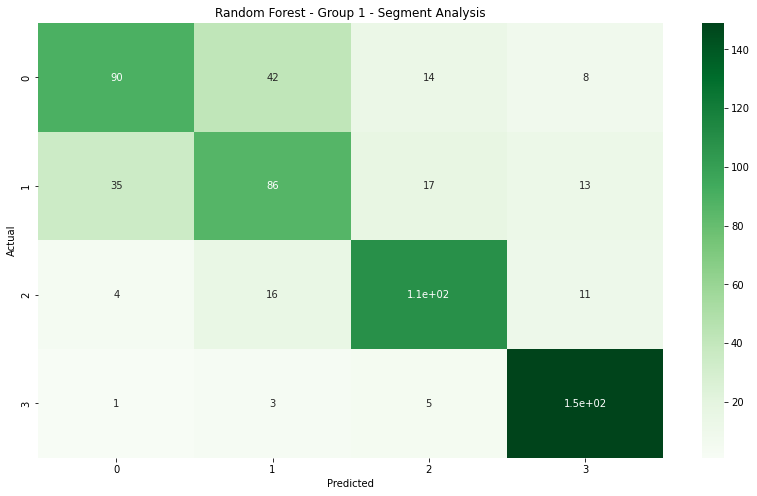

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7497727949566029; Accuracy score = 0.7579298831385642 ; Precisison Score = 0.7462817180421639; Recall score = 0.7579298831385642


 Aggregate report 
               precision    recall  f1-score   support

           0       0.69      0.66      0.67       149
           1       0.58      0.49      0.53       144
           2       0.81      0.92      0.86       166
           3       0.90      0.95      0.92       140

    accuracy                           0.76       599
   macro avg       0.75      0.75      0.75       599
weighted avg       0.75      0.76      0.75       599



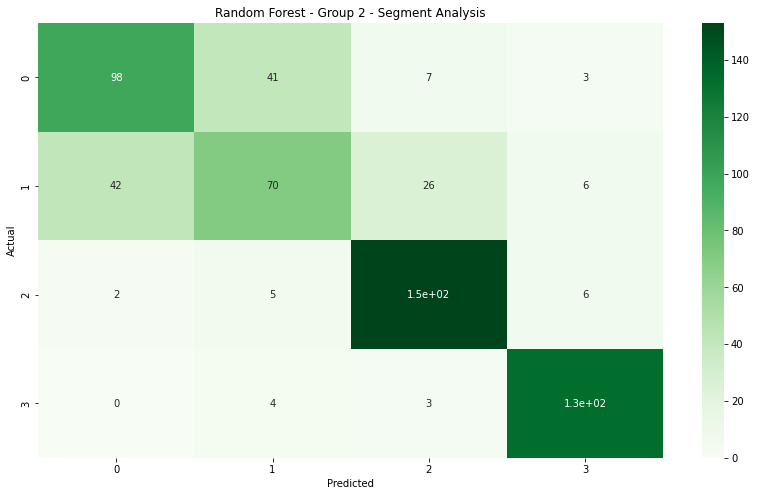

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.8270277582232528; Accuracy score = 0.8266666666666667 ; Precisison Score = 0.8448344988344988; Recall score = 0.8266666666666667


 Aggregate report 
               precision    recall  f1-score   support

           0       0.85      0.61      0.71        18
           1       0.95      0.90      0.93        21
           2       0.90      0.90      0.90        20
           3       0.64      0.88      0.74        16

    accuracy                           0.83        75
   macro avg       0.83      0.82      0.82        75
weighted avg       0.84      0.83      0.83        75



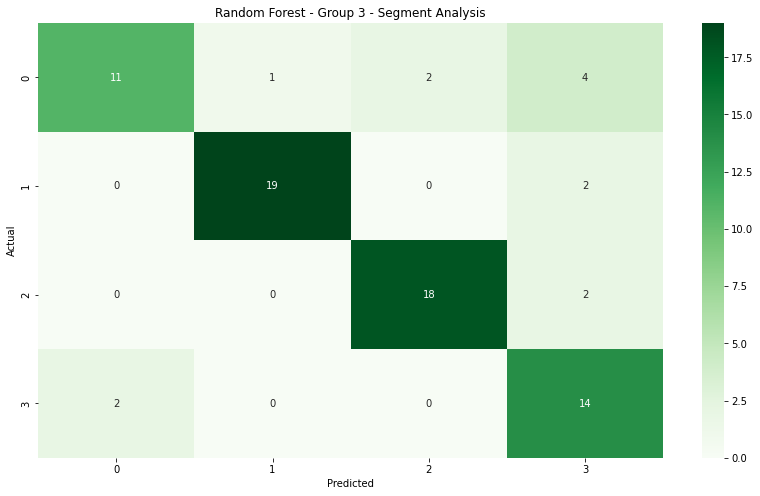

In [209]:
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
n_estimators = [1600, 1600, 600]
max_features = ['sqrt', 'auto', 'auto']
max_depth = [122, 38, 80]
min_samples_split = [5, 5, 5]
min_samples_leaf = [1, 1, 1]
bootstrap = ['False', ]

for i in range(3):
    rtree = RandomForestClassifier(
      n_estimators = n_estimators[i],
      max_features = max_features[i],
      max_depth = max_depth[i],
      min_samples_split = 5,
      min_samples_leaf = 1,
      bootstrap = 'False'
    )
    actual, predicted, X_test_list[i] = run_model(rtree, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"Random Forest - Group {i+1} - Segment Analysis", actual, predicted, ['0', '1', '2', '3'])

#### Performance of Random Forest - Parent Level



 Aggregate report 
               precision    recall  f1-score   support

           0       0.57      0.48      0.52        61
           1       0.40      0.37      0.38        49
           2       0.50      0.63      0.56        41
           3       0.71      0.75      0.73        52

    accuracy                           0.55       203
   macro avg       0.54      0.56      0.55       203
weighted avg       0.55      0.55      0.55       203



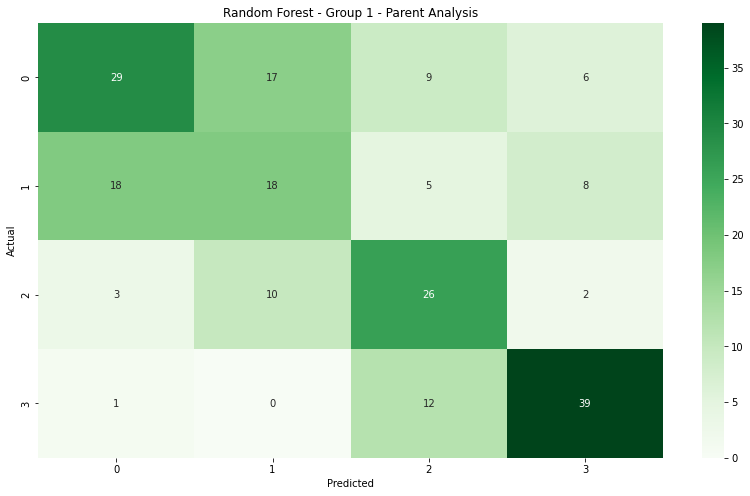



 Aggregate report 
               precision    recall  f1-score   support

           0       0.67      0.76      0.71        41
           1       0.63      0.52      0.57        46
           2       0.70      0.78      0.74        49
           3       0.82      0.78      0.80        36

    accuracy                           0.70       172
   macro avg       0.71      0.71      0.71       172
weighted avg       0.70      0.70      0.70       172



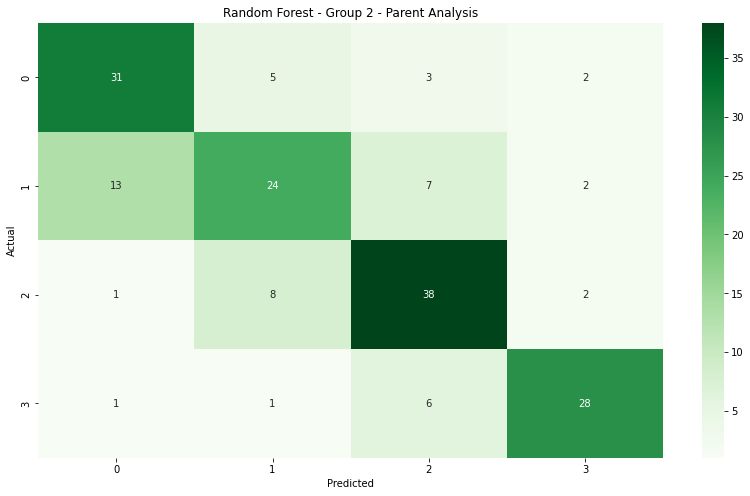



 Aggregate report 
               precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.57      0.57      0.57         7
           2       0.29      0.50      0.36         4
           3       0.75      0.64      0.69        14

    accuracy                           0.62        37
   macro avg       0.58      0.60      0.58        37
weighted avg       0.66      0.62      0.63        37



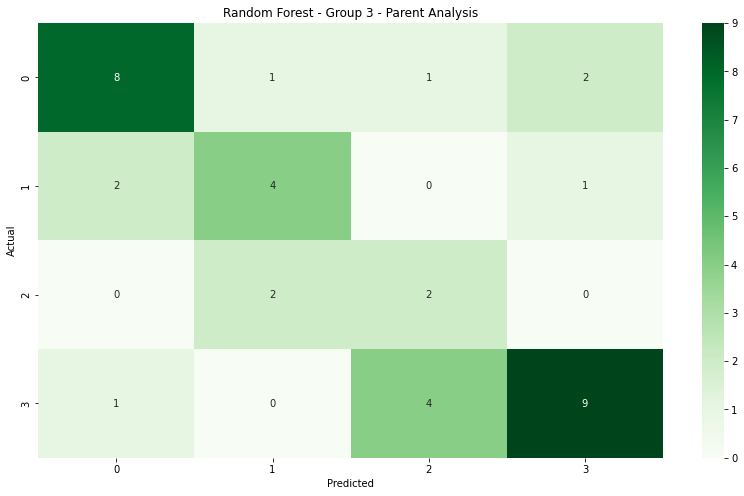

In [210]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"Random Forest - Group {i+1} - Parent Analysis", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])


## Ada Boost

adaboost with decision tree base

In [211]:
quick_parameters = {
  'base_estimator' : [dtree],
  'n_estimators' : [10, 20, 50, 100],
  'learning_rate' : [ 0.01, 0.1, 1, 10]
}

adtree = AdaBoostClassifier()
# hyperparameter_tuning(adtree, data_balanced_np, label_balanced_np, quick_parameters)
# hyperparameter_tuning(adtree, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)
# hyperparameter_tuning(adtree, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

***NOTE: The above code block takes a lot of time to run because it does a massive GridSearch. We have pasted the final results of the GridSearch below for all three groups:***

Group 1 (all data): {'base_estimator': DecisionTreeClassifier(max_depth=18), 'learning_rate': 1, 'n_estimators': 50}

Group 2 (non noisy): {'base_estimator': DecisionTreeClassifier(max_depth=18), 'learning_rate': 1, 'n_estimators': 20}

Group 3 (noisy): {'base_estimator': DecisionTreeClassifier(max_depth=18), 'learning_rate': 0.1, 'n_estimators': 20}

#### Performance of Ada Boost with Decision Tree Base - Segment Level

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6862046966155688; Accuracy score = 0.6898839137645107 ; Precisison Score = 0.6924308133061242; Recall score = 0.6898839137645107


 Aggregate report 
               precision    recall  f1-score   support

           0       0.54      0.70      0.61       153
           1       0.54      0.42      0.47       156
           2       0.80      0.74      0.77       161
           3       0.91      0.94      0.93       133

    accuracy                           0.69       603
   macro avg       0.70      0.70      0.69       603
weighted avg       0.69      0.69      0.69       603



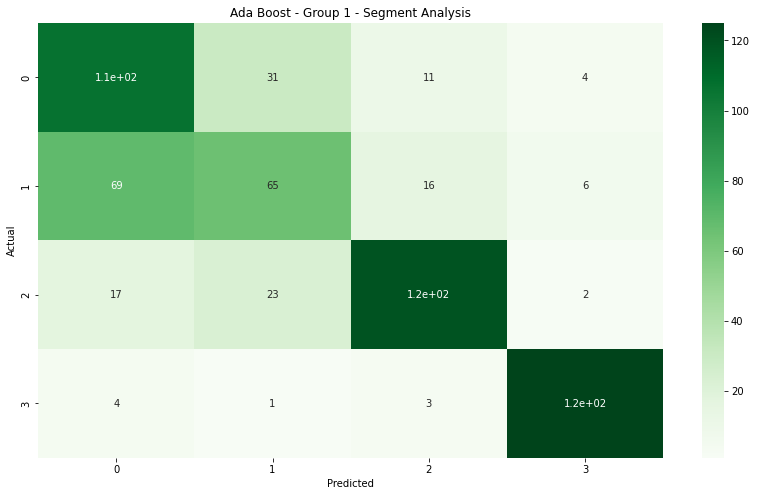

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7262832240243676; Accuracy score = 0.7328881469115192 ; Precisison Score = 0.7218306230548858; Recall score = 0.7328881469115192


 Aggregate report 
               precision    recall  f1-score   support

           0       0.59      0.58      0.59       142
           1       0.56      0.50      0.53       155
           2       0.83      0.86      0.85       155
           3       0.91      0.99      0.95       147

    accuracy                           0.73       599
   macro avg       0.72      0.73      0.73       599
weighted avg       0.72      0.73      0.73       599



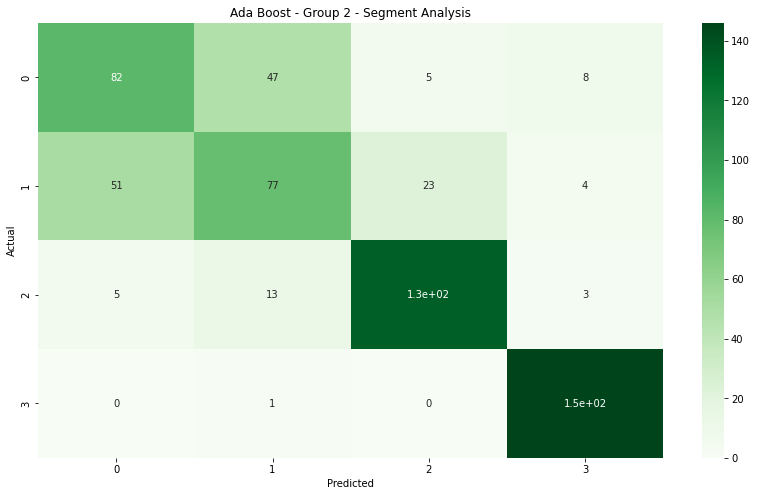

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7552920449363678; Accuracy score = 0.76 ; Precisison Score = 0.755699096225412; Recall score = 0.76


 Aggregate report 
               precision    recall  f1-score   support

           0       0.62      0.56      0.59        18
           1       0.82      0.86      0.84        21
           2       0.78      0.93      0.85        15
           3       0.79      0.71      0.75        21

    accuracy                           0.76        75
   macro avg       0.75      0.77      0.76        75
weighted avg       0.76      0.76      0.76        75



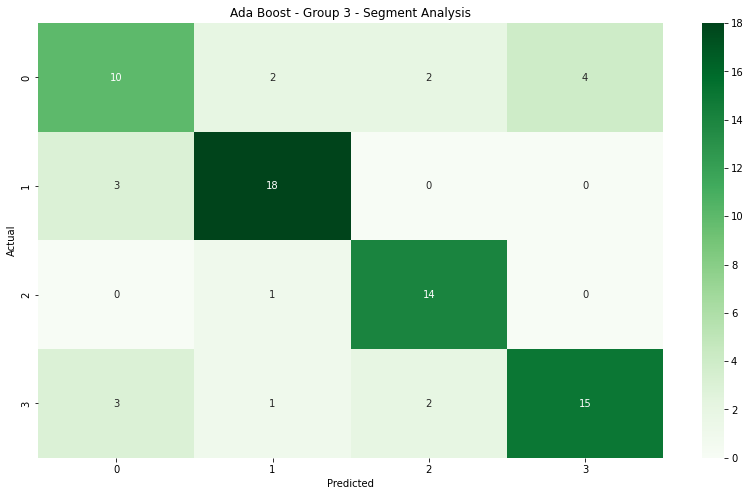

In [212]:
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
n_estimators = [50, 20, 20]
learning_rate = [1, 1, 0.1]

for i in range(3):
    adtree = AdaBoostClassifier(base_estimator = dtree, n_estimators=n_estimators[i], learning_rate=learning_rate[i])
    actual, predicted, X_test_list[i] = run_model(adtree, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"Ada Boost - Group {i+1} - Segment Analysis", actual, predicted, ['0', '1', '2', '3'])

#### Performance of Ada Boost with Decision Tree Base - Parent Level



 Aggregate report 
               precision    recall  f1-score   support

           0       0.64      0.59      0.61        63
           1       0.48      0.47      0.47        47
           2       0.57      0.69      0.62        49
           3       0.87      0.78      0.82        50

    accuracy                           0.63       209
   macro avg       0.64      0.63      0.63       209
weighted avg       0.64      0.63      0.63       209



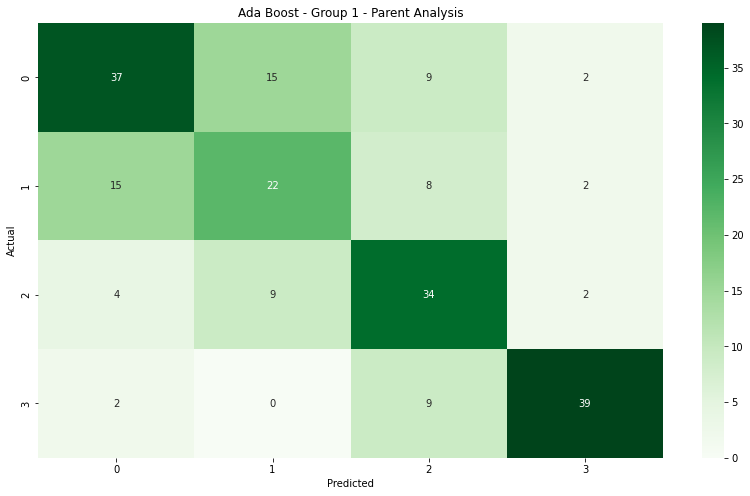



 Aggregate report 
               precision    recall  f1-score   support

           0       0.49      0.45      0.47        47
           1       0.50      0.52      0.51        52
           2       0.64      0.72      0.68        47
           3       0.78      0.69      0.74        36

    accuracy                           0.59       182
   macro avg       0.60      0.60      0.60       182
weighted avg       0.59      0.59      0.59       182



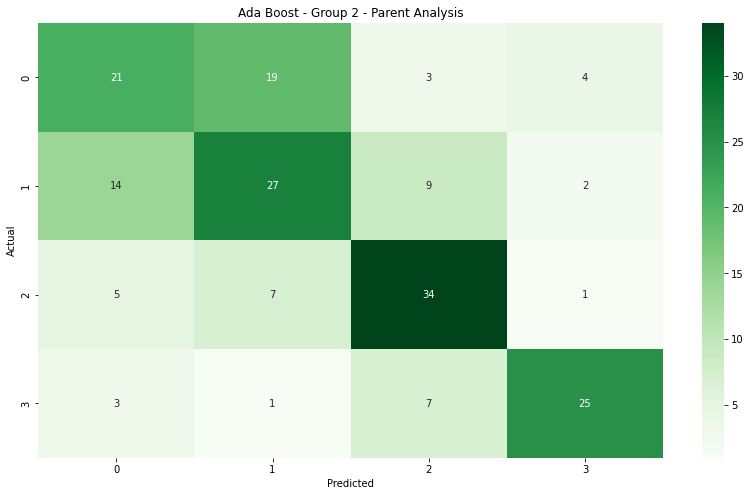



 Aggregate report 
               precision    recall  f1-score   support

           0       0.78      0.54      0.64        13
           1       0.71      0.62      0.67         8
           2       0.22      0.67      0.33         3
           3       0.71      0.67      0.69        15

    accuracy                           0.62        39
   macro avg       0.61      0.62      0.58        39
weighted avg       0.70      0.62      0.64        39



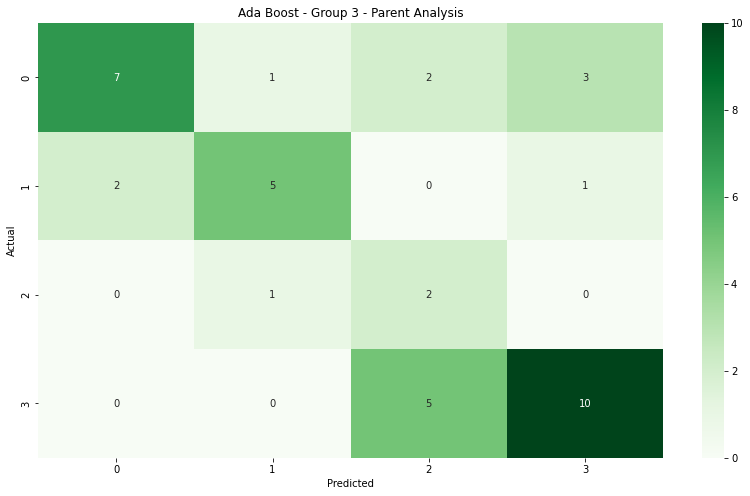

In [213]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"Ada Boost - Group {i+1} - Parent Analysis", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

## XG Boost

In [214]:
quick_parameters = {
  'min_child_weight': [1, 5, 10, 15],
  'gamma': [0.5, 1, 1.5, 2, 5],
  'subsample': [0.6, 0.8, 1.0],
  'colsample_bytree': [0.6, 0.8, 1.0],
  'max_depth': [2, 5, 10, 15],
  'alpha' : [0.1, 1, 3, 6],
  'lambda' :  [1, 3, 6],
  'max_delta_step' : [2],
  'objective' : ['reg:squarederror'],
  'eta' :  [ 0.01, 0.1, 1, 10],
  'num_boost_round' : [5]
}

xgtree = XGBClassifier()
# hyperparameter_tuning_random(xgtree, data_balanced_np, label_balanced_np, quick_parameters)
# hyperparameter_tuning_random(xgtree, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)
# hyperparameter_tuning_random(xgtree, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

***NOTE: The above code block takes a lot of time to run because it does a massive GridSearch. We have pasted the final results of the GridSearch below for all three groups:***

Group 1 (all data): {'subsample': 1.0, 'objective': 'reg:squarederror', 'num_boost_round': 5, 'min_child_weight': 5, 'max_depth': 5, 'max_delta_step': 2, 'lambda': 3, 'gamma': 1, 'eta': 1, 'colsample_bytree': 0.8, 'alpha': 0.1}


Group 2 (non noisy): {'subsample': 0.8, 'objective': 'reg:squarederror', 'num_boost_round': 5, 'min_child_weight': 1, 'max_depth': 10, 'max_delta_step': 2, 'lambda': 1, 'gamma': 1, 'eta': 0.1, 'colsample_bytree': 0.6, 'alpha': 0.1}


Group 3 (noisy): {'subsample': 1.0, 'objective': 'reg:squarederror', 'num_boost_round': 5, 'min_child_weight': 1, 'max_depth': 5, 'max_delta_step': 2, 'lambda': 6, 'gamma': 0.5, 'eta': 0.1, 'colsample_bytree': 1.0, 'alpha': 1}

#### Performance of XG Boost - Segment Level

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
[15:47:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:47:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


F1 score = 0.7219101054165381; Accuracy score = 0.724709784411277 ; Precisison Score = 0.7204061875520473; Recall score = 0.724709784411277


 Aggregate report 
               precision    recall  f1-score   support

           0       0.67      0.61      0.64       158
           1       0.53      0.53      0.53       125
           2       0.75      0.76      0.75       159
           3       0.89      0.95      0.92       161

    accuracy                           0.72       603
   macro avg       0.71      0.71      0.71       603
weighted avg       0.72      0.72      0.72       603



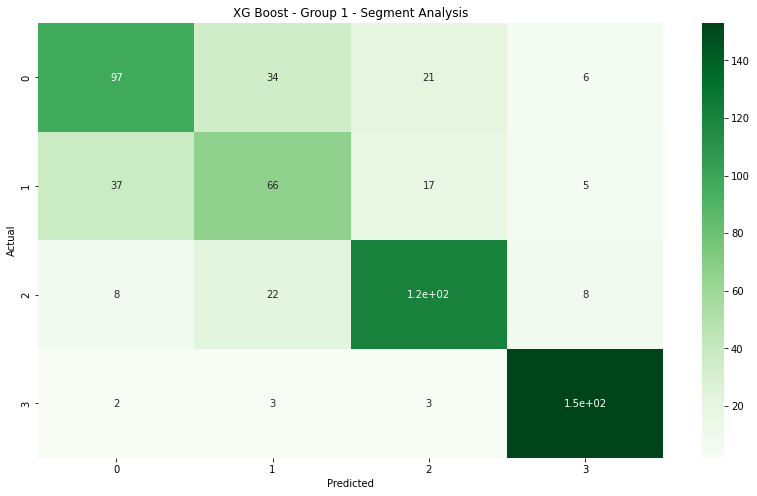

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
[15:47:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:47:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


F1 score = 0.7314340950638858; Accuracy score = 0.7345575959933222 ; Precisison Score = 0.7313435357344721; Recall score = 0.7345575959933222


 Aggregate report 
               precision    recall  f1-score   support

           0       0.68      0.64      0.66       148
           1       0.53      0.53      0.53       131
           2       0.82      0.76      0.79       173
           3       0.86      0.99      0.92       147

    accuracy                           0.73       599
   macro avg       0.72      0.73      0.72       599
weighted avg       0.73      0.73      0.73       599



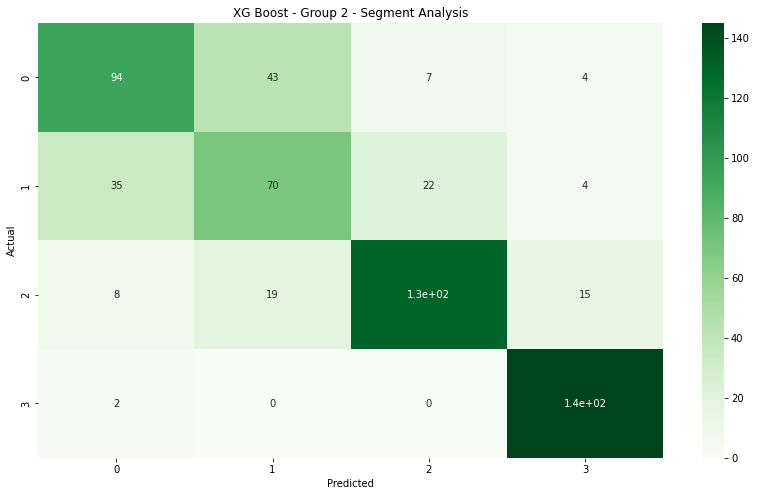

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
[15:47:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:47:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


F1 score = 0.6464402996971146; Accuracy score = 0.6533333333333333 ; Precisison Score = 0.6497838799898297; Recall score = 0.6533333333333333


 Aggregate report 
               precision    recall  f1-score   support

           0       0.53      0.53      0.53        15
           1       0.74      0.93      0.82        15
           2       0.65      0.68      0.67        22
           3       0.67      0.52      0.59        23

    accuracy                           0.65        75
   macro avg       0.65      0.67      0.65        75
weighted avg       0.65      0.65      0.65        75



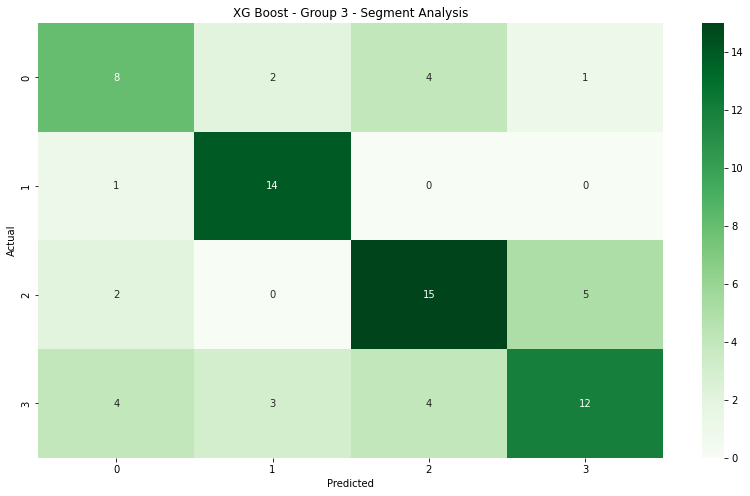

In [215]:
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
min_child_weight = [5, 1, 1]
gamma =[1, 1, 0.5]
subsample = [1.0,0.8,1.0]
colsample_bytree = [0.8, 0.6, 1.0]
max_depth = [5, 10,5]
alpha = [0.1, 0.1, 1]
lmbda = [3,1,6]
eta =  [ 1, 0.1, 0.1]

for i in range(3):
    myVar = {
      'lambda': lmbda[i],
    }
    xgtree = XGBClassifier(
      min_child_weight = min_child_weight[i],
      gamma = gamma[i],
      subsample = subsample[i],
      colsample_bytree = colsample_bytree[i],
      max_depth = max_depth[i],
      alpha = alpha[i],
      # lambda_ = lmbda[i],
      max_delta_step = 2,
      objective = 'reg:squarederror',
      eta =  eta[i],
      num_boost_round = 5,
      **myVar
    )

    temp_xg_df = copy.deepcopy(lst_df[i])

    for col in temp_xg_df:
      if col not in ["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"]:
        temp_xg_df[col] = temp_xg_df[col].astype(str).astype(float)

    actual, predicted, X_test_list[i] = run_model(xgtree, temp_xg_df, lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"XG Boost - Group {i+1} - Segment Analysis", actual, predicted, ['0', '1', '2', '3'])

#### Performance of XG Boost - Parent Level



 Aggregate report 
               precision    recall  f1-score   support

           0       0.54      0.50      0.52        62
           1       0.45      0.40      0.42        48
           2       0.57      0.72      0.64        50
           3       0.82      0.79      0.80        52

    accuracy                           0.60       212
   macro avg       0.60      0.60      0.60       212
weighted avg       0.60      0.60      0.60       212



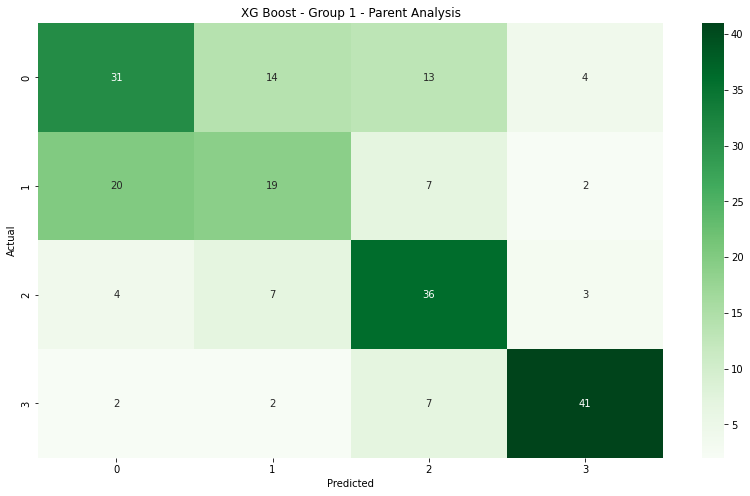



 Aggregate report 
               precision    recall  f1-score   support

           0       0.66      0.63      0.65        49
           1       0.51      0.48      0.49        42
           2       0.66      0.76      0.70        49
           3       0.81      0.76      0.78        38

    accuracy                           0.66       178
   macro avg       0.66      0.66      0.66       178
weighted avg       0.66      0.66      0.66       178



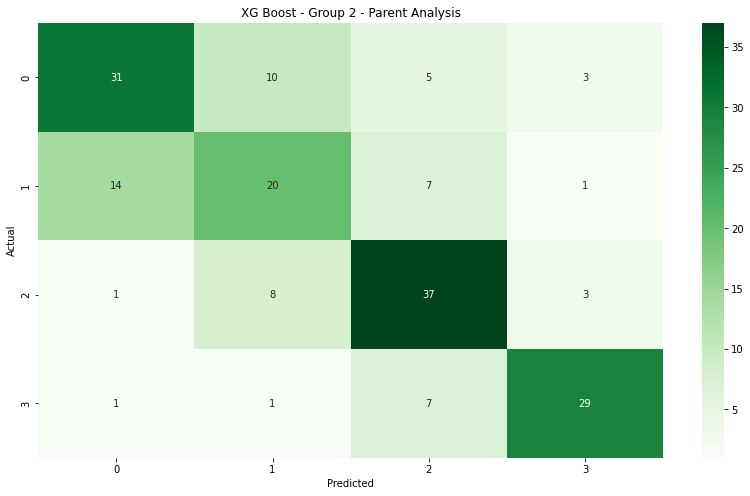



 Aggregate report 
               precision    recall  f1-score   support

           0       0.55      0.55      0.55        11
           1       0.50      0.57      0.53         7
           2       0.25      0.33      0.29         6
           3       0.78      0.58      0.67        12

    accuracy                           0.53        36
   macro avg       0.52      0.51      0.51        36
weighted avg       0.56      0.53      0.54        36



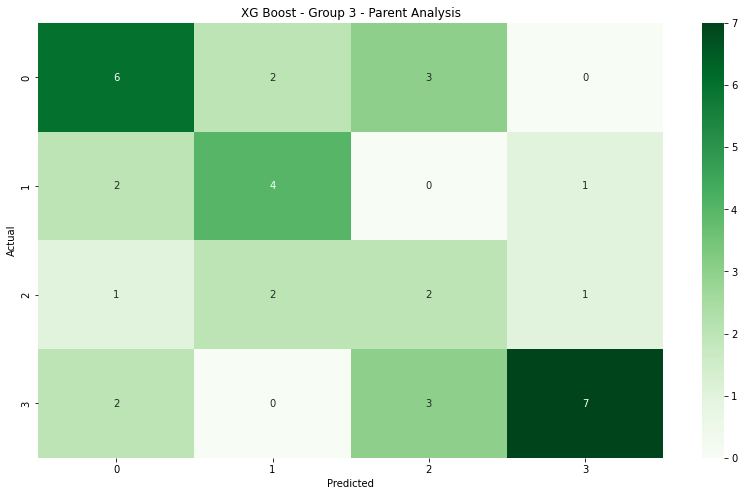

In [216]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"XG Boost - Group {i+1} - Parent Analysis", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

## Gradient Boosting

In [217]:
quick_parameters = {
  'loss' : ["deviance"],
  'learning_rate' : [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
  'min_samples_split' : np.linspace(0.01, 0.5, 14),
  'min_samples_leaf' : np.linspace(0.001, 0.5, 18),
  'max_depth' : [1,2,3,5,8],
  'max_features' : ["log2","sqrt"],
  'criterion' : ["friedman_mse",  "absolute_error"],
  'subsample' : [0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
  'n_estimators' : [10, 20, 30, 50]
}

gbtree = GradientBoostingClassifier()
# hyperparameter_tuning_random(gbtree, data_balanced_np, label_balanced_np, quick_parameters)
# hyperparameter_tuning_random(gbtree, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)
# hyperparameter_tuning_random(gbtree, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

***NOTE: The above code block takes a lot of time to run because it does a massive GridSearch. We have pasted the final results of the GridSearch below for all three groups:***

Group 1 (all data): {'subsample': 1.0, 'n_estimators': 20, 'min_samples_split': 0.047692307692307694, 'min_samples_leaf': 0.11841176470588236, 'max_features': 'sqrt', 'max_depth': 8, 'loss': 'deviance', 'learning_rate': 0.3, 'criterion': 'friedman_mse'}

Group 2 (non noisy): {'subsample': 1.0, 'n_estimators': 50, 'min_samples_split': 0.12307692307692307, 'min_samples_leaf': 0.001, 'max_features': 'log2', 'max_depth': 3, 'loss': 'deviance', 'learning_rate': 0.025, 'criterion': 'friedman_mse'}

Group 3 (noisy): {'subsample': 0.95, 'n_estimators': 20, 'min_samples_split': 0.12307692307692307, 'min_samples_leaf': 0.11841176470588236, 'max_features': 'sqrt', 'max_depth': 5, 'loss': 'deviance', 'learning_rate': 0.1, 'criterion': 'friedman_mse'}

#### Performance of Gradient Boosting - Segment Level

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.5112017826670707; Accuracy score = 0.5190713101160862 ; Precisison Score = 0.510983380779337; Recall score = 0.5190713101160862


 Aggregate report 
               precision    recall  f1-score   support

           0       0.52      0.57      0.54       145
           1       0.47      0.41      0.44       157
           2       0.47      0.38      0.42       157
           3       0.59      0.74      0.65       144

    accuracy                           0.52       603
   macro avg       0.51      0.52      0.51       603
weighted avg       0.51      0.52      0.51       603



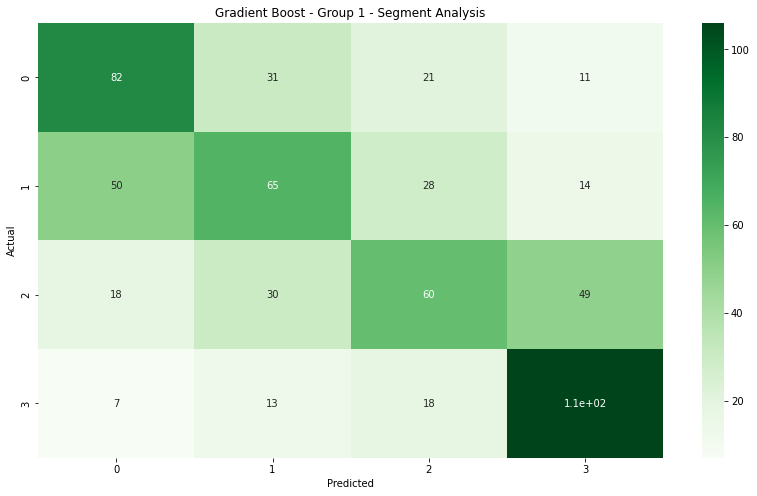

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.5547896640310559; Accuracy score = 0.5642737896494157 ; Precisison Score = 0.554506457614789; Recall score = 0.5642737896494157


 Aggregate report 
               precision    recall  f1-score   support

           0       0.59      0.53      0.56       144
           1       0.45      0.36      0.40       148
           2       0.55      0.54      0.54       157
           3       0.63      0.82      0.71       150

    accuracy                           0.56       599
   macro avg       0.55      0.56      0.55       599
weighted avg       0.55      0.56      0.55       599



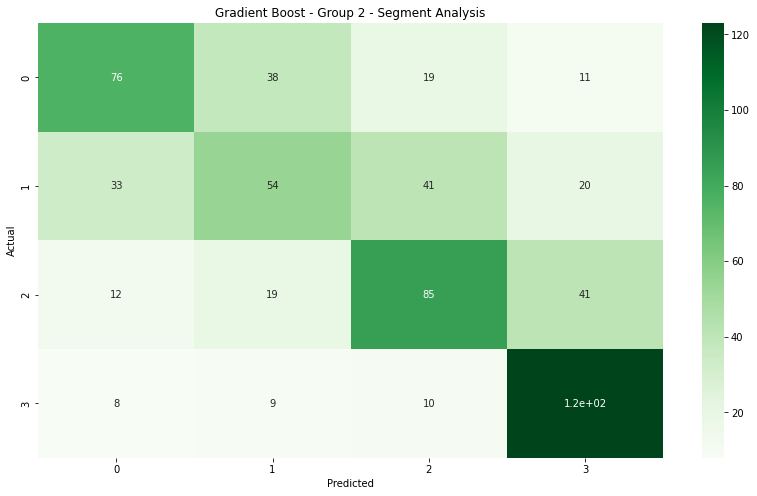

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6567740489434969; Accuracy score = 0.6666666666666666 ; Precisison Score = 0.6761282389108476; Recall score = 0.6666666666666666


 Aggregate report 
               precision    recall  f1-score   support

           0       0.67      0.50      0.57        20
           1       0.70      0.89      0.78        18
           2       0.59      0.81      0.68        16
           3       0.73      0.52      0.61        21

    accuracy                           0.67        75
   macro avg       0.67      0.68      0.66        75
weighted avg       0.68      0.67      0.66        75



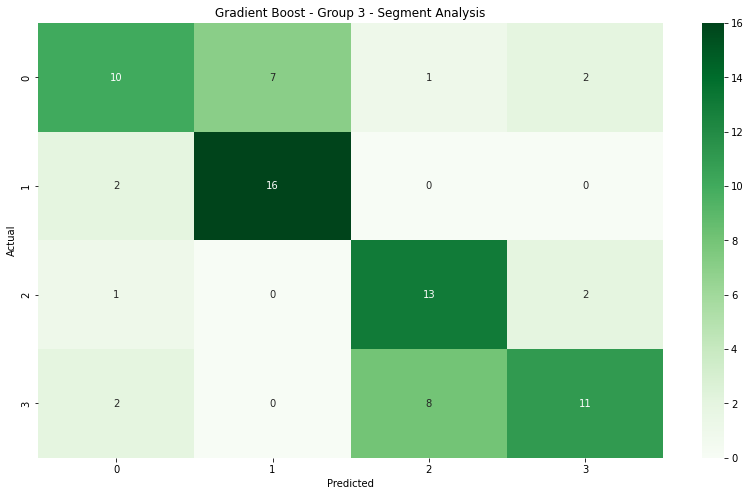

In [218]:
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
learning_rate = [0.3, 0.025, 0.1]
min_samples_split = [0.05, 0.12, 0.12]
min_samples_leaf = [0.12, 0.001, 0.12]
max_depth = [8, 3, 5]
max_features = ["sqrt","log2","sqrt"]
subsample = [1.0, 1.0, 0.95]
n_estimators = [20, 50, 20]

for i in range(3):
    gbtree = GradientBoostingClassifier(
      loss = "deviance",
      learning_rate = learning_rate[i],
      min_samples_split = min_samples_split[i],
      min_samples_leaf = min_samples_leaf[i],
      max_depth = max_depth[i],
      max_features = max_features[i],
      criterion = "friedman_mse",
      subsample = subsample[i],
      n_estimators = n_estimators[i]
    )
    actual, predicted, X_test_list[i] = run_model(gbtree, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"Gradient Boost - Group {i+1} - Segment Analysis", actual, predicted, ['0', '1', '2', '3'])

#### Performance of Gradient Boosting - Parent Level



 Aggregate report 
               precision    recall  f1-score   support

           0       0.54      0.50      0.52        62
           1       0.42      0.36      0.39        45
           2       0.44      0.46      0.45        50
           3       0.52      0.62      0.56        50

    accuracy                           0.49       207
   macro avg       0.48      0.48      0.48       207
weighted avg       0.49      0.49      0.48       207



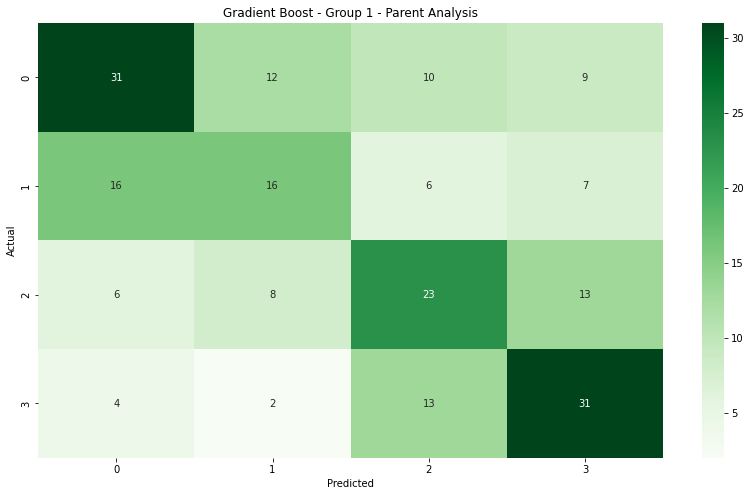



 Aggregate report 
               precision    recall  f1-score   support

           0       0.37      0.35      0.36        40
           1       0.47      0.31      0.37        49
           2       0.44      0.45      0.45        44
           3       0.47      0.70      0.57        37

    accuracy                           0.44       170
   macro avg       0.44      0.45      0.44       170
weighted avg       0.44      0.44      0.43       170



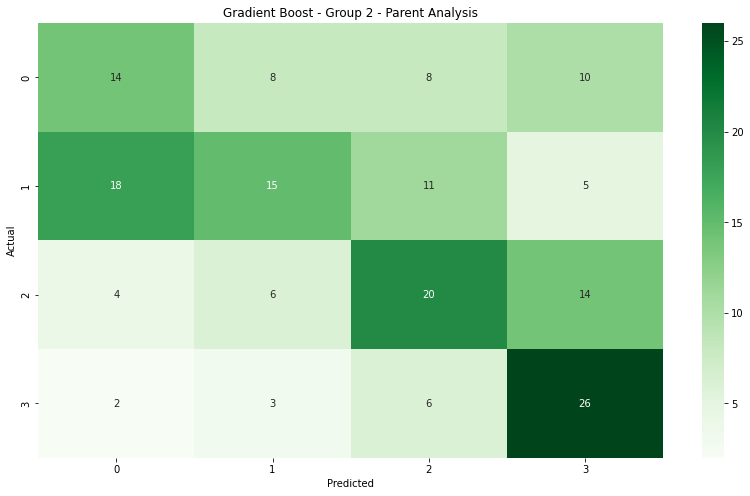



 Aggregate report 
               precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       0.64      1.00      0.78         7
           2       0.17      0.50      0.25         2
           3       0.73      0.57      0.64        14

    accuracy                           0.63        35
   macro avg       0.60      0.64      0.57        35
weighted avg       0.72      0.63      0.64        35



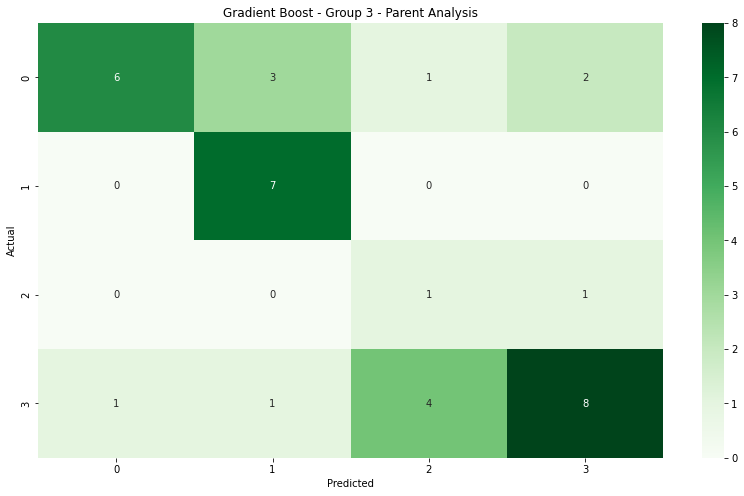

In [219]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"Gradient Boost - Group {i+1} - Parent Analysis", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

## Plot the current results

### Segment Analysis

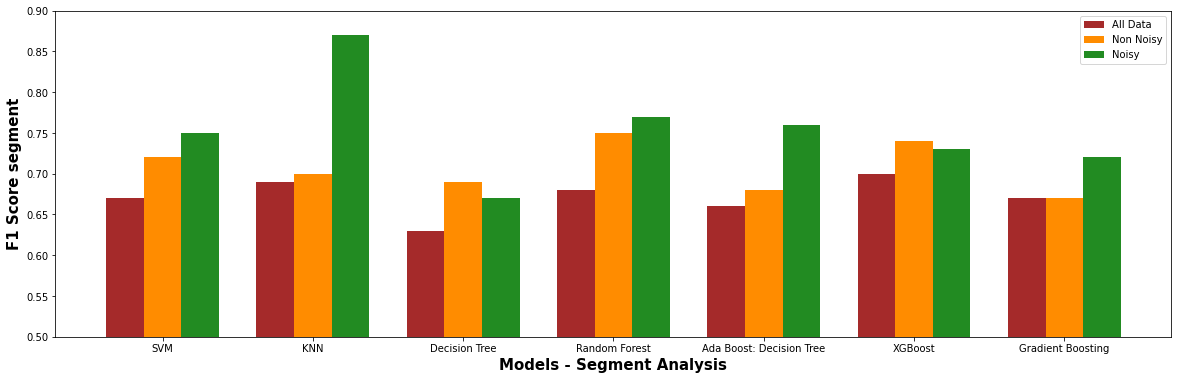

In [220]:
#f1 scores entered manually to control for randomization
f1_all = [0.67, 0.69, 0.63, 0.68, 0.66, 0.70, 0.67 ]
f1_non_noisy = [0.72, 0.70, 0.69, 0.75, 0.68, 0.74, 0.67]
f1_noisy = [0.75, 0.87, 0.67, 0.77, 0.76, 0.73, 0.72]
    
barWidth = 0.25
fig = plt.subplots(figsize =(20, 6))
 
# Set position of bar on X axis
br1 = np.arange(len(f1_all))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, f1_all, color ='brown', width = barWidth, label ='All Data')
plt.bar(br2, f1_non_noisy, color ='darkorange', width = barWidth, label ='Non Noisy')
plt.bar(br3, f1_noisy, color ='forestgreen', width = barWidth, label ='Noisy')
 
# Adding Xticks
plt.xlabel('Models - Segment Analysis', fontweight ='bold', fontsize = 15)
plt.ylabel('F1 Score segment', fontweight ='bold', fontsize = 15)
plt.ylim([0.5, 0.9])
plt.xticks([r + barWidth for r in range(len(f1_all))],
        ['SVM', 'KNN', 'Decision Tree', 'Random Forest', 'Ada Boost: Decision Tree', 'XGBoost', 'Gradient Boosting'])
 
plt.legend()
plt.show()

### Parent Analysis

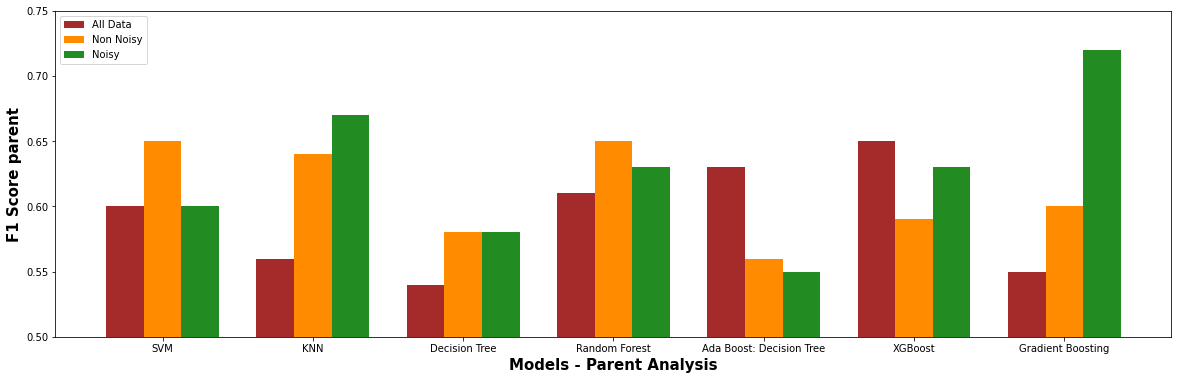

In [221]:
#f1 scores entered manually to control for randomization
f1_all = [0.60, 0.56, 0.54, 0.61, 0.63, 0.65, 0.55]
f1_non_noisy = [0.65, 0.64, 0.58, 0.65, 0.56, 0.59, 0.60]
f1_noisy = [0.60, 0.67, 0.58, 0.63, 0.55, 0.63, 0.72]
    
barWidth = 0.25
fig = plt.subplots(figsize =(20, 6))
 
# Set position of bar on X axis
br1 = np.arange(len(f1_all))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, f1_all, color ='brown', width = barWidth, label ='All Data')
plt.bar(br2, f1_non_noisy, color ='darkorange', width = barWidth, label ='Non Noisy')
plt.bar(br3, f1_noisy, color ='forestgreen', width = barWidth, label ='Noisy')
 
# Adding Xticks
plt.xlabel('Models - Parent Analysis', fontweight ='bold', fontsize = 15)
plt.ylabel('F1 Score parent', fontweight ='bold', fontsize = 15)
plt.ylim([0.5, 0.75])
plt.xticks([r + barWidth for r in range(len(f1_all))],
        ['SVM', 'KNN', 'Decision Tree', 'Random Forest', 'Ada Boost: Decision Tree', 'XGBoost', 'Gradient Boosting'])
 
plt.legend()
plt.show()

# Final Models (on same train and test sets)

- **Just doing one test/train split for all models in the models below.**
- Validation is not required as we have set the hyper parameters then trained each of the models on this same training set

In [222]:
def run_model_pre_split(ml_model, X_train, X_test, y_train, y_test):
    model = copy.deepcopy(ml_model)
    
    # Only train on this feature set
    feature_set = X_train.drop(['parent_file_train']+feature_labels,axis=1).columns  # Only these features will be fed to the model
    
    actual_labels = np.empty([0], dtype=int)
    predicted_labels = np.empty([0], dtype=int)

    model.fit(X_train[feature_set], y_train)
    y_pred = model.predict(X_test[feature_set])
    
    X_test['segment_predictions'] = y_pred  # To store prediction with rest of the data

    actual_labels = np.append(actual_labels, y_test)
    predicted_labels = np.append(predicted_labels, y_pred)

    acc_score = accuracy_score(y_test, y_pred)
    prec_score = precision_score(y_test, y_pred, average='weighted')
    rec_score = recall_score(y_test, y_pred, average='weighted')
    fone_score = f1_score(y_test, y_pred, average='weighted')

    print(f'F1 score = {fone_score}; Accuracy score = {acc_score} ; Precisison Score = {prec_score}; Recall score = {rec_score}')

    return actual_labels, predicted_labels, X_test

#### Train and Test data for all the three groups.

In [223]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(standardized_aggression_df_balanced, label_balanced_np, test_size=0.25)

In [224]:
X_train_non_noisy, X_test_non_noisy, y_train_non_noisy, y_test_non_noisy = train_test_split(standardized_non_noisy_df_balanced, label_balanced_non_noisy_np, test_size=0.25)

In [225]:
X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(standardized_noisy_df_balanced, label_balanced_noisy_np, test_size=0.25)

## SVM - Final Model with the same train/test split

#### Segment Analysis

In [226]:
label = 'segment_label_train'
X_test_list_svm = [None,None,None]
kernel = ['rbf','rbf','poly']
gamma = ['auto', 'scale', 'auto']
c = [100000, 1000, 1000]
predicted_svm = [None, None, None]
actual_svm = [None, None, None]
X_train = [X_train_all, X_train_non_noisy, X_train_noisy]
X_test = [X_test_all, X_test_non_noisy, X_test_noisy]
y_train = [y_train_all, y_train_non_noisy, y_train_noisy]
y_test = [y_test_all, y_test_non_noisy, y_test_noisy]

for i in range(3):
    svm_model = svm.SVC(kernel=kernel[i], gamma=gamma[i], C=c[i], degree= 3)
    actual_svm[i], predicted_svm[i], X_test_list_svm[i] = run_model_pre_split(svm_model, X_train[i], X_test[i], y_train[i], y_test[i])

F1 score = 0.682747283696415; Accuracy score = 0.6882255389718076 ; Precisison Score = 0.6793481763224497; Recall score = 0.6882255389718076
F1 score = 0.7168062977769034; Accuracy score = 0.7245409015025042 ; Precisison Score = 0.7135464926799295; Recall score = 0.7245409015025042
F1 score = 0.6992081867229651; Accuracy score = 0.7066666666666667 ; Precisison Score = 0.7226990553306343; Recall score = 0.7066666666666667


#### Parent Analysis

In [227]:
max_parent_df_list_svm = [None, None, None]

for i in range(0,len(X_test_list_svm)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list_svm[i]
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list_svm[i] = df_i_merged
    print(f"F1 score = {f1_score(max_parent_df_list_svm[i]['segment_predictions'], max_parent_df_list_svm[i]['parent_label_train'], average='weighted')}")

F1 score = 0.6480697056899177
F1 score = 0.6573439682111574
F1 score = 0.5132253711201079


## KNN - Final Model with the same train/test split

#### Segment Analysis

In [228]:
X_test_list_knn = [None,None,None]
predicted_knn = [None, None, None]
actual_knn = [None, None, None]
metric = ['manhattan','manhattan','euclidean']

for i in range(3):
    knn = KNeighborsClassifier(n_neighbors= 1,algorithm='auto',leaf_size= 1, metric= metric[i],weights='uniform')
    actual_knn[i], predicted_knn[i], X_test_list_knn[i] = run_model_pre_split(knn, X_train[i], X_test[i], y_train[i], y_test[i])

F1 score = 0.6957838618105436; Accuracy score = 0.703150912106136 ; Precisison Score = 0.6930840354670076; Recall score = 0.703150912106136
F1 score = 0.709200023830609; Accuracy score = 0.7212020033388982 ; Precisison Score = 0.7090505760547758; Recall score = 0.7212020033388982
F1 score = 0.7290012901712408; Accuracy score = 0.7333333333333333 ; Precisison Score = 0.7569847696163485; Recall score = 0.7333333333333333


#### Parent Analysis

In [229]:
max_parent_df_list_knn = [None, None, None]

for i in range(0,len(X_test_list_knn)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list_knn[i]
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list_knn[i] = df_i_merged
    print(f"F1 score = {f1_score(max_parent_df_list_knn[i]['parent_label_train'], max_parent_df_list_knn[i]['segment_predictions'], average='weighted')}")

F1 score = 0.6248418415731077
F1 score = 0.5914451762882603
F1 score = 0.5970053338474393


## Decision Tree - Final Model with the same train/test split

#### Segment Analysis

In [230]:
X_test_list_dt = [None,None,None]
predicted_dt = [None, None, None]
actual_dt = [None, None, None]
criterion = ['entropy','entropy','gini']
max_depth = [30,20,18]

for i in range(3):
    dtree = DecisionTreeClassifier(criterion=criterion[i], max_depth=max_depth[i])
    actual_dt[i], predicted_dt[i], X_test_list_dt[i] = run_model_pre_split(dtree, X_train[i], X_test[i], y_train[i], y_test[i])

F1 score = 0.679055557395511; Accuracy score = 0.6882255389718076 ; Precisison Score = 0.6751263035397352; Recall score = 0.6882255389718076
F1 score = 0.6995185058311729; Accuracy score = 0.7095158597662772 ; Precisison Score = 0.7006492301984789; Recall score = 0.7095158597662772
F1 score = 0.6509185185185186; Accuracy score = 0.6666666666666666 ; Precisison Score = 0.6893290391841116; Recall score = 0.6666666666666666


#### Parent Analysis

In [231]:
max_parent_df_list_dt = [None, None, None]

for i in range(0,len(X_test_list_dt)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list_dt[i]
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list_dt[i] = df_i_merged
    print(f"F1 score = {f1_score(max_parent_df_list_dt[i]['parent_label_train'], max_parent_df_list_dt[i]['segment_predictions'], average='weighted')}")

F1 score = 0.631678597364872
F1 score = 0.5628419047229265
F1 score = 0.5534147869674185


## Random Forest - Final Model with the same train/test split

#### Segment Analysis

In [232]:
X_test_list_rf = [None,None,None]
predicted_rf = [None, None, None]
actual_rf = [None, None, None]
n_estimators = [1600, 1600, 600]
max_features = ['sqrt', 'auto', 'auto']
max_depth = [122, 38, 80]

for i in range(3):
    rtree = RandomForestClassifier(
      n_estimators = n_estimators[i],
      max_features = max_features[i],
      max_depth = max_depth[i],
      min_samples_split = 5,
      min_samples_leaf = 1,
      bootstrap = 'False'
    )
    actual_rf[i], predicted_rf[i], X_test_list_rf[i] = run_model_pre_split(rtree, X_train[i], X_test[i], y_train[i], y_test[i])

F1 score = 0.7207611474763522; Accuracy score = 0.724709784411277 ; Precisison Score = 0.7198801684195606; Recall score = 0.724709784411277
F1 score = 0.7653388951749684; Accuracy score = 0.7696160267111853 ; Precisison Score = 0.7663241608313094; Recall score = 0.7696160267111853
F1 score = 0.7191260766779731; Accuracy score = 0.7333333333333333 ; Precisison Score = 0.7348732278740804; Recall score = 0.7333333333333333


#### Parent Analysis

In [233]:
max_parent_df_list_rf = [None, None, None]

for i in range(0,len(X_test_list_rf)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list_rf[i]
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list_rf[i] = df_i_merged
    print(f"F1 score = {f1_score(max_parent_df_list_rf[i]['parent_label_train'], max_parent_df_list_rf[i]['segment_predictions'], average='weighted')}")

F1 score = 0.6655090520687886
F1 score = 0.6574771141735049
F1 score = 0.5554887218045113


## Ada Boost with Decision tree base - Final Model with the same train/test split

#### Segment Analysis

In [234]:
X_test_list_ad = [None,None,None]
predicted_ad = [None, None, None]
actual_ad = [None, None, None]
n_estimators = [50, 20, 20]
learning_rate = [1, 1, 0.1]

for i in range(3):
    adtree = AdaBoostClassifier(base_estimator = dtree, n_estimators=n_estimators[i], learning_rate=learning_rate[i])
    actual_ad[i], predicted_ad[i], X_test_list_ad[i] = run_model_pre_split(adtree, X_train[i], X_test[i], y_train[i], y_test[i])

F1 score = 0.682494280807994; Accuracy score = 0.6882255389718076 ; Precisison Score = 0.6788837015159185; Recall score = 0.6882255389718076
F1 score = 0.7580332176822668; Accuracy score = 0.7646076794657763 ; Precisison Score = 0.7586367469830422; Recall score = 0.7646076794657763
F1 score = 0.6815118632818981; Accuracy score = 0.6933333333333334 ; Precisison Score = 0.7112326888797477; Recall score = 0.6933333333333334


#### Parent Analysis

In [235]:
max_parent_df_list_ad = [None, None, None]

for i in range(0,len(X_test_list_ad)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list_ad[i]
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list_ad[i] = df_i_merged
    print(f"F1 score = {f1_score(max_parent_df_list_ad[i]['parent_label_train'], max_parent_df_list_ad[i]['segment_predictions'], average='weighted')}")

F1 score = 0.6133575892139245
F1 score = 0.637424726600639
F1 score = 0.506169730546462


## XGBoost - Final Model with the same train/test split

#### Segment Analysis

In [236]:
X_test_list_xg = [None,None,None]
predicted_xg = [None, None, None]
actual_xg = [None, None, None]
min_child_weight = [5, 1, 1]
gamma =[1, 1, 0.5]
subsample = [1.0,0.8,1.0]
colsample_bytree = [0.8, 0.6, 1.0]
max_depth = [5, 10,5]
alpha = [0.1, 0.1, 1]
lmbda = [3,1,6]
eta =  [ 1, 0.1, 0.1]

for i in range(3):
    myVar = {
      'lambda': lmbda[i],
    }
    xgtree = XGBClassifier(
      min_child_weight = min_child_weight[i],
      gamma = gamma[i],
      subsample = subsample[i],
      colsample_bytree = colsample_bytree[i],
      max_depth = max_depth[i],
      alpha = alpha[i],
      # lambda_ = lmbda[i],
      max_delta_step = 2,
      objective = 'reg:squarederror',
      eta =  eta[i],
      num_boost_round = 5,
      **myVar
    )

    temp_xg_train = copy.deepcopy(X_train[i])

    for col in temp_xg_train:
      if col not in ["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"]:
        temp_xg_train[col] = temp_xg_train[col].astype(str).astype(float)

    temp_xg_test = copy.deepcopy(X_test[i])

    for col in temp_xg_test:
      if col not in ["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"]:
        temp_xg_test[col] = temp_xg_test[col].astype(str).astype(float)

    actual_xg[i], predicted_xg[i], X_test_list_xg[i] = run_model_pre_split(xgtree, temp_xg_train, temp_xg_test, y_train[i], y_test[i])

C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:47:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:47:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 score = 0.6869026784014328; Accuracy score = 0.6898839137645107 ; Precisison Score = 0.684678088416688; Recall score = 0.6898839137645107
[15:47:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boo

C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


F1 score = 0.7427307532321822; Accuracy score = 0.7479131886477463 ; Precisison Score = 0.7444953096619406; Recall score = 0.7479131886477463
[15:48:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:48:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


F1 score = 0.7837780534877309; Accuracy score = 0.7866666666666666 ; Precisison Score = 0.7991176527176528; Recall score = 0.7866666666666666


#### Parent Analysis

In [237]:
max_parent_df_list_xg = [None, None, None]

for i in range(0,len(X_test_list_xg)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list_xg[i]
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list_xg[i] = df_i_merged
    print(f"F1 score = {f1_score(max_parent_df_list_xg[i]['parent_label_train'], max_parent_df_list_xg[i]['segment_predictions'], average='weighted')}")

F1 score = 0.6450768721934613
F1 score = 0.6366223675193725
F1 score = 0.5992481203007519


## Gradient Boosting - Final Model with the same train/test split

#### Segment Analysis

In [238]:
X_test_list_gb = [None,None,None]
predicted_gb = [None, None, None]
actual_gb = [None, None, None]
learning_rate = [0.3, 0.025, 0.1]
min_samples_split = [0.05, 0.12, 0.12]
min_samples_leaf = [0.12, 0.001, 0.12]
max_depth = [8, 3, 5]
max_features = ["sqrt","log2","sqrt"]
subsample = [1.0, 1.0, 0.95]
n_estimators = [20, 50, 20]

for i in range(3):
    gbtree = GradientBoostingClassifier(
      loss = "deviance",
      learning_rate = learning_rate[i],
      min_samples_split = min_samples_split[i],
      min_samples_leaf = min_samples_leaf[i],
      max_depth = max_depth[i],
      max_features = max_features[i],
      criterion = "friedman_mse",
      subsample = subsample[i],
      n_estimators = n_estimators[i]
    )
    actual_gb[i], predicted_gb[i], X_test_list_gb[i] = run_model_pre_split(gbtree, X_train[i], X_test[i], y_train[i], y_test[i])

F1 score = 0.5389332230880212; Accuracy score = 0.5456053067993366 ; Precisison Score = 0.5358753353378738; Recall score = 0.5456053067993366
F1 score = 0.567735257653237; Accuracy score = 0.5692821368948247 ; Precisison Score = 0.5703070558593383; Recall score = 0.5692821368948247
F1 score = 0.698615213461271; Accuracy score = 0.7066666666666667 ; Precisison Score = 0.7238888888888888; Recall score = 0.7066666666666667


#### Parent Analysis

In [239]:
max_parent_df_list_gb = [None, None, None]

for i in range(0,len(X_test_list_gb)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list_gb[i]
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list_gb[i] = df_i_merged
    print(f"F1 score = {f1_score(max_parent_df_list_gb[i]['parent_label_train'], max_parent_df_list_gb[i]['segment_predictions'], average='weighted')}")

F1 score = 0.5035167015289314
F1 score = 0.4458562968000064
F1 score = 0.567704555506413


## Ensemble

### Group 1 - All data

In [240]:
predicted_all = [predicted_svm[0],predicted_knn[0], predicted_dt[0], predicted_rf[0], predicted_ad[0], predicted_xg[0], predicted_gb[0]]

Equally balanced models, i.e. max vote

In [241]:
label = [0] * len(predicted_all[0])

for i in range(len(predicted_all[0])):
  for model in predicted_all:
    label[i] = label[i] + model[i]
  label[i] = label[i]/7

round to label

In [242]:
final_all_label = [round(x) for x in label]

Calculate f1 score

In [243]:
fone_score = f1_score(y_test_all, final_all_label, average='weighted')
print(fone_score)

0.7149631902206902


Fetch parent labels

In [244]:
X_test_list_gb[0]["ensemble"] = final_all_label

max_parent_df_list_gb = [None, None, None]


df_i = X_test_list_gb[0]
df_i_merged = df_i.groupby('parent_file_train')['ensemble'].max().reset_index()

# Get parent label for each parent_file
df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
max_parent_df_list_gb[0] = df_i_merged
print(f"F1 score = {f1_score(max_parent_df_list_gb[0]['parent_label_train'], max_parent_df_list_gb[0]['ensemble'], average='weighted')}")

F1 score = 0.6352945449081122


### Group 2 - Non Noisy data

In [245]:
predicted_non_noisy = [predicted_svm[1],predicted_knn[1], predicted_dt[1], predicted_rf[1], predicted_ad[1], predicted_xg[1], predicted_gb[1]]

Equally balanced models, i.e. max vote

In [246]:
label = [0] * len(predicted_non_noisy[0])

for i in range(len(predicted_non_noisy[0])):
  for model in predicted_non_noisy:
    label[i] = label[i] + model[i]
  label[i] = label[i]/7

round to label

In [247]:
final_non_noisy_label = [round(x) for x in label]

Calculate f1 score

In [248]:
fone_score = f1_score(y_test_non_noisy, final_non_noisy_label, average='weighted')
print(fone_score)

0.7578436375934393


Fetch parent labels

In [249]:
X_test_list_gb[1]["ensemble"] = final_non_noisy_label

max_parent_df_list_gb = [None, None, None]


df_i = X_test_list_gb[1]
df_i_merged = df_i.groupby('parent_file_train')['ensemble'].max().reset_index()

# Get parent label for each parent_file
df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
max_parent_df_list_gb[1] = df_i_merged
print(f"F1 score = {f1_score(max_parent_df_list_gb[1]['parent_label_train'], max_parent_df_list_gb[1]['ensemble'], average='weighted')}")

F1 score = 0.6480395632419611


### Group 3 - Noisy data

In [250]:
predicted_noisy = [predicted_svm[2],predicted_knn[2], predicted_dt[2], predicted_rf[2], predicted_ad[2], predicted_xg[2], predicted_gb[2]]

Equally balanced models, i.e. max vote

In [251]:
label = [0] * len(predicted_noisy[0])

for i in range(len(predicted_noisy[0])):
  for model in predicted_noisy:
    label[i] = label[i] + model[i]
  label[i] = label[i]/7

round to label

In [252]:
final_noisy_label = [round(x) for x in label]

Calculate f1 score

In [253]:
fone_score = f1_score(y_test_noisy, final_noisy_label, average='weighted')
print(fone_score)

0.6563165963165964


Fetch parent labels

In [254]:
X_test_list_gb[2]["ensemble"] = final_noisy_label

max_parent_df_list_gb = [None, None, None]


df_i = X_test_list_gb[2]
df_i_merged = df_i.groupby('parent_file_train')['ensemble'].max().reset_index()

# Get parent label for each parent_file
df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
max_parent_df_list_gb[2] = df_i_merged
print(f"F1 score = {f1_score(max_parent_df_list_gb[2]['parent_label_train'], max_parent_df_list_gb[2]['ensemble'], average='weighted')}")

F1 score = 0.4576051372450265


# Visualize final models with the same test set

## Segment Analysis

Hard coded values to avoid randomization of splits

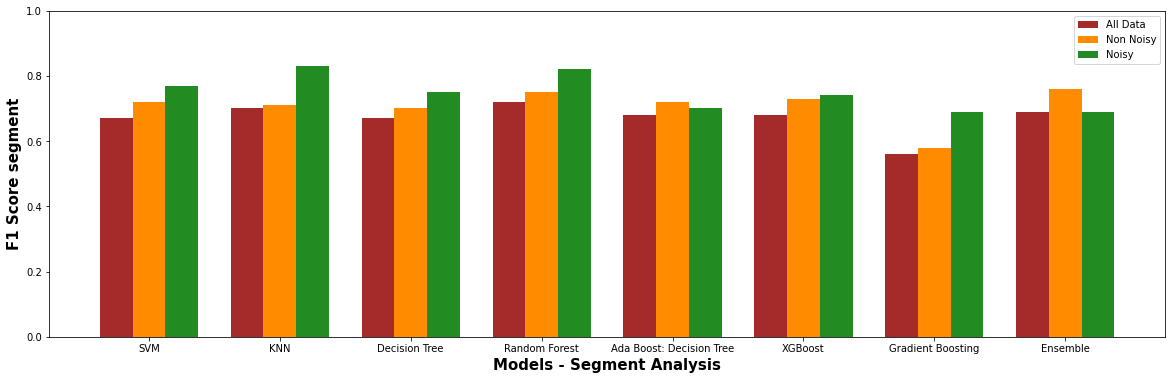

In [255]:
#f1 scores entered manually to control for randomization
f1_all = [0.67, 0.70, 0.67, 0.72, 0.68, 0.68, 0.56, 0.69]
f1_non_noisy = [0.72, 0.71, 0.70, 0.75, 0.72, 0.73, 0.58, 0.76]
f1_noisy = [0.77, 0.83, 0.75, 0.82, 0.70, 0.74, 0.69, 0.69]
    
barWidth = 0.25
fig = plt.subplots(figsize =(20, 6))
 
# Set position of bar on X axis
br1 = np.arange(len(f1_all))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, f1_all, color ='brown', width = barWidth, label ='All Data')
plt.bar(br2, f1_non_noisy, color ='darkorange', width = barWidth, label ='Non Noisy')
plt.bar(br3, f1_noisy, color ='forestgreen', width = barWidth, label ='Noisy')
 
# Adding Xticks
plt.xlabel('Models - Segment Analysis', fontweight ='bold', fontsize = 15)
plt.ylabel('F1 Score segment', fontweight ='bold', fontsize = 15)
plt.ylim([0, 1])
plt.xticks([r + barWidth for r in range(len(f1_all))],
        ['SVM', 'KNN', 'Decision Tree', 'Random Forest', 'Ada Boost: Decision Tree', 'XGBoost', 'Gradient Boosting', 'Ensemble'])
 
plt.legend()
plt.show()

## Parent Analysis

Hard coded values to avoid randomization of splits

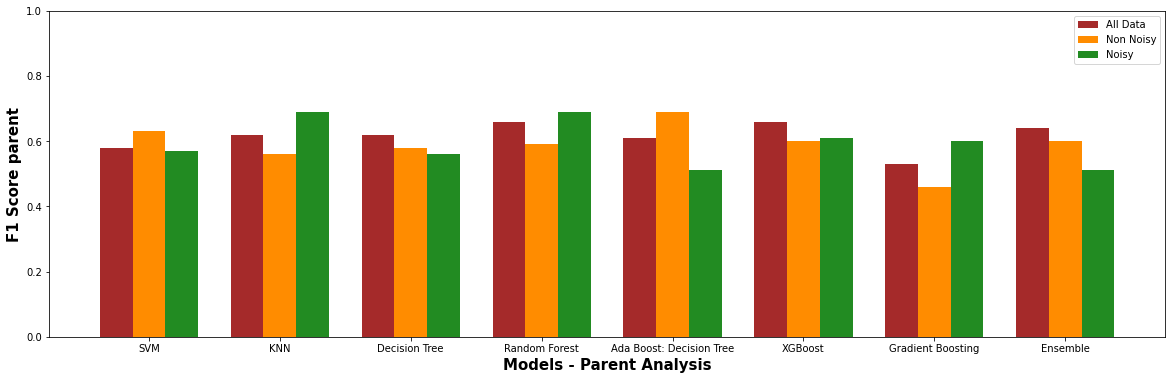

In [256]:
#f1 scores entered manually to control for randomization
f1_all = [0.58, 0.62, 0.62, 0.66, 0.61, 0.66, 0.53, 0.64]
f1_non_noisy = [0.63, 0.56, 0.58, 0.59, 0.69, 0.60, 0.46, 0.60]
f1_noisy = [0.57, 0.69, 0.56, 0.69, 0.51, 0.61, 0.60, 0.51]
    
barWidth = 0.25
fig = plt.subplots(figsize =(20, 6))
 
# Set position of bar on X axis
br1 = np.arange(len(f1_all))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, f1_all, color ='brown', width = barWidth, label ='All Data')
plt.bar(br2, f1_non_noisy, color ='darkorange', width = barWidth, label ='Non Noisy')
plt.bar(br3, f1_noisy, color ='forestgreen', width = barWidth, label ='Noisy')
 
# Adding Xticks
plt.xlabel('Models - Parent Analysis', fontweight ='bold', fontsize = 15)
plt.ylabel('F1 Score parent', fontweight ='bold', fontsize = 15)
plt.ylim([0, 1])
plt.xticks([r + barWidth for r in range(len(f1_all))],
        ['SVM', 'KNN', 'Decision Tree', 'Random Forest', 'Ada Boost: Decision Tree', 'XGBoost', 'Gradient Boosting', 'Ensemble'])
 
plt.legend()
plt.show()